#### File Setup

In [6]:
import pandas as pd 
import numpy as np
import re
import tabulate
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib
import seaborn as sns 
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
from statsmodels.miscmodels.ordinal_model import OrderedModel
import mord 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

#### Data Cleaning & Set-up

In [46]:
df = pd.read_csv(csv_file)


#### Basic Data Cleaning 

In [47]:
##### Data cleaning to change column types

#drop anyone not sorted into condition -- did not complete 
df_clean = df.drop(df[df['Condition'].isna()].index)

#change data type to int 
df_clean['Condition'] =  df_clean['Condition'].astype('int64')

# create frame column gain or loss condition based on condition value 
df_clean['frame'] = df_clean['Condition'].apply(lambda x: 'Gain' if x < 3 else 'Loss')

#filter only where progress = 100% 
df_clean = df_clean[df_clean['Progress']==100]


##### Survey Time / Completion

In [48]:
##Review avg times 
print(df_clean['Duration (in seconds)'].describe())

count       263.000000
mean       2280.391635
std       18053.102777
min          43.000000
25%         190.000000
50%         302.000000
75%         659.000000
max      241785.000000
Name: Duration (in seconds), dtype: float64


In [49]:
##Remove participants failing manipualtion checks and outside of time range
# quarterlie range
quartiles = df_clean['Duration (in seconds)'].quantile([0.25, 0.75])
iqr = quartiles[0.75] - quartiles[0.25]
lower_bound = quartiles[0.25] - 1.5 * iqr
upper_bound = quartiles[0.75] + 1.5 * iqr

#remove outlier
df_clean = df_clean[(df_clean['Duration (in seconds)'] >= lower_bound) & (df_clean['Duration (in seconds)'] <= upper_bound)]


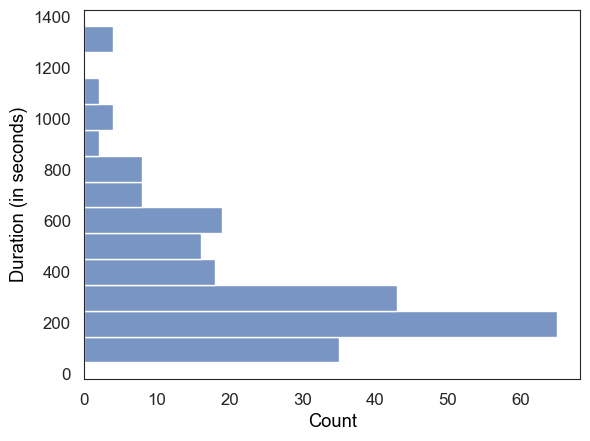

In [50]:
##Plot Avg Completion Times 
df_clean['Duration (in seconds)'].describe()
sns.histplot( y='Duration (in seconds)', data =df_clean)
plt.show()

##### Mapping Columns & Cleaning

In [51]:
#### Creating columns and grouping for various scenarios:
#filter to option columns only
columns = df_clean.columns 
option_columns = [col for col in columns if 'Option' in col]

# dictionary mapping
scenario_dict = {"GS1":"animals_gain", "GS2":"forest_gain", "GS3":"humans_gain", "LS1":"animals_loss", "LS2":"forest_loss", "LS3":"humans_loss"  }

#set columns based on scenario 
def scenario(row):
    for col in option_columns:
        if pd.notnull(row[col]):
            match = re.search(r'(GS\d+|LS\d+)', col)
            if match:
                return match.group()
    return None

# get scenario from dictionary 
def get_scenario(row):
    value = row['scenario']
    if value in scenario_dict:
        return scenario_dict[value]
    return None

# match scenario to dict
df_clean['scenario'] = df_clean[option_columns].apply(lambda row: scenario(row), axis=1)
df_clean['scenario_mapped'] = df_clean.apply(lambda row: get_scenario(row), axis=1)


In [52]:
##### Option Column Cleaning
# select option columns 
df_clean['option_selected'] = df_clean[option_columns].fillna(method='ffill', axis=1).iloc[:, -1]
##option_columns = ['Q12. GS1, Option','Q12. GS2, Option', 'Q12. GS3, Option.', 'Q12. LS1, Option', 'Q12. LS2, Option', 'Q12. LS3, Option']

# Rating column clean & creation 
rating_columns = ['Q13. GS1, Rating','Q13. GS2, Rating', 'Q13. GS3, Rating', 'Q13. LS1, Rating', 'Q13. LS2, Rating', 'Q13. LS3, Rating']
#create a new rating column containing the non-null values of the rating columns 
df_clean['rating'] = df_clean[rating_columns].fillna(method='ffill', axis=1).iloc[:, -1]
# drop where rating is na 
df_clean = df_clean[df_clean['rating'].notna()]
# get the number only from the column 
df_clean['rating_num'] = df_clean['rating'].apply(lambda x: x.split(":")[0])
# change to integer for calculation 
df_clean['rating_num'] = df_clean['rating_num'].astype('int')
#categorize rating categories
df_clean['rating_cat'] = df_clean['rating'].apply(lambda x: x.split(":")[1])
df_clean['rating_cat'] = df_clean['rating_cat'].apply(lambda x: x.strip())
rating_order =  [ 'Strong Preference for Proposal A', 'Preference for Proposal A', 'Slight Preference for Proposal A',  'No Preference for Proposal A or B',   'Slight Preference for Propsal B',  'Preference for Proposal B','Strong Preference for Proposal B']
df_clean['rating_cat'] = df_clean['rating_cat'].astype('category').cat.set_categories(rating_order, ordered=True)
df_clean['rating_cat'] = df_clean['rating'].apply(lambda x: x.split(":")[1])
df_clean['rating_cat'] = df_clean['rating_cat'].apply(lambda x: x.strip())
rating_order =  [ 'Strong Preference for Proposal A', 'Preference for Proposal A', 'Slight Preference for Proposal A',  'No Preference for Proposal A or B',   'Slight Preference for Propsal B',  'Preference for Proposal B','Strong Preference for Proposal B']
df_clean['rating_cat'] = df_clean['rating_cat'].astype('category').cat.set_categories(rating_order, ordered=True)

# Rationale column cleaning
rationale_columns = ['Q13. GS1, Rationale','Q14. GS2, Rationale', 'Q14. GS3, Rationle', 'Q14. LS1, Rationale', 'Q14. LS2, Rationale', 'Q14. LS3, Rationale']
# create a new rationale column containing the non-null values of the rating columns 
df_clean['rationale'] = df_clean[rationale_columns].fillna(method='ffill', axis=1).iloc[:, -1]

##look where rating is appr. 
df_clean = df_clean[((df_clean['option_selected']=='Proposal A') & (df_clean['rating_num']<= 4 )) | ((df_clean['option_selected']=='Proposal B') & (df_clean['rating_num'] >= 4 ))]

### Drop standalone choice, rationale, and rating columns
colu = rationale_columns + option_columns + rating_columns
df_clean = df_clean.drop(colu, axis= 'columns')
df_clean.shape


(202, 84)

In [53]:
### Cleaning and dropping time columns 
columns = list(df_clean.columns)

###  First click columns
time_click1 = [col for col in columns if 'first click' in col.lower()]
#time first click for the scenario 
time_click1_scn = [string for string in time_click1 if string.startswith('Q10')]
#make as 1 column 
df_clean['scn_t_first_click'] = df_clean[time_click1_scn].fillna(method='ffill', axis=1).iloc[:, -1]

### Last click columns
time_click2 = [col for col in columns if 'last click' in col.lower()]
time_click2_scn = [string for string in time_click2 if string.startswith('Q10')]
df_clean['scn_t_last_click'] = df_clean[time_click2_scn].fillna(method='ffill', axis=1).iloc[:, -1]

### Time Submit Scenario columns
time_submit = [col for col in columns if 'submit' in col.lower()]
time_submit_scn = [string for string in time_submit if string.startswith('Q10')]
df_clean['scn_t_submit'] = df_clean[time_submit_scn].fillna(method='ffill', axis=1).iloc[:, -1]

#click_count1_scn = [string for string in click_count1 if 'dem' in string.lower()]

## drop Q10 time columns 
columns_drop = time_click2_scn + time_click1_scn + time_submit_scn
df_clean = df_clean.drop(columns_drop, axis = 'columns')

##Click count cleaning 
columns = list(df_clean.columns)
## Click Count for Scenario 
click_count1 = [col for col in columns if 'click count' in col.lower()]
#filer only scenario click coun t
click_count_scn = [string for string in click_count1 if string.startswith('Q10')]
#make as 1 column for all scenarios 
df_clean['scn_click_count'] = df_clean[click_count_scn].fillna(method='ffill', axis=1).iloc[:, -1]

## Click Count for Scenario 
click_count = [col for col in columns if 'click count' in col.lower()]
click_count1_dem = [string for string in click_count if 'dem' in string.lower()]
df_clean['dem_click_count'] = df_clean[click_count1_dem].fillna(method='ffill', axis=1).iloc[:, -1]

# drop scenario and dem click count columns 
columns_drop = click_count_scn + click_count1_dem
df_clean = df_clean.drop(columns_drop, axis = 'columns')

### drop metadata or misc columns from analysis 
metadata_or_misc = ['Q1. Metadata_Browser','Q1. Metadata_Version', 'Q1. Metadata_Operating System','Q1. Metadata_Resolution', 'UserLanguage', 'DistributionChannel', 'Status']
df_clean = df_clean.drop(metadata_or_misc, axis = 'columns')

In [54]:
##Scenario Times
scenario_times = ['scn_t_first_click',  'scn_t_last_click', 'scn_t_submit']
df_clean[scenario_times]
#create column for total time for scenario question: 
df_clean['scenario_time_to_choose'] = df_clean['scn_t_last_click'] - df_clean['scn_t_first_click']
df_clean['scenario_total_time'] = df_clean['scn_t_submit'] - df_clean['scn_t_first_click']
scenario_time = ['scenario_time_to_choose', 'scenario_total_time']
df_clean[scenario_time].describe()

,scenario_time_to_choose,scenario_total_time
count,202.000000,202.000000
mean,83.914396,96.429817
std,110.245975,111.308231
min,0.489000,1.678000
25%,17.011250,30.414750
50%,46.614500,63.165500
75%,107.802750,118.370000
max,776.420000,779.137000


### Demographics

##### Cleaning 

In [55]:
#Rename columns 
df_clean = df_clean.rename(columns={
    'Q5. Age': 'age',
    'Q6. Gender': 'gender',
    'Q6. Gender_4_TEXT': 'gender_text',
    'Q8. Ethnicity': 'ethnicity',
    'Q8. Ethnicity_6_TEXT': 'ethnicity_text',
    'Q9. Education': 'education',
    'Q10. Country': 'country',
    'Q10. Student': 'student',
    'Q91': 'ADP_familiar'
})

###coutry name clean 
import pycountry_convert as pc

#function to rename messy countries
def rename_countries(country):
    if pd.isnull(country):  # Check if the value is nan
        return country
    if country in ['United States of America', 'USA', 'US', 'us', 'usa', 'America', 'America   ', 'the United States', 'The United States',  'United States ', 'Amrican', 'United States', 'Florida', 'New York', 'MA', 'NZ', 'North Carolina', 'Newyork', 'denver', 'New York, USA','LA' , 'Mississippi', 'Texas'   ]:
        return 'USA'
    elif country in ['United Kingdom', 'United Kingdom ', 'UK', 'England', 'England ', 'Cambridge', 'London', 'uuk', 'U.K.', 'uk', 'Britain', 'Wales', 'Uk', 'West Norwood']:
        return 'UK'
    elif country in ['the Netherlands', 'The netherlands', 'Netherlands']:
        return 'Netherlands'
    elif country in ['China', '中国', 'Chinese ', '美国','加州']:
        return 'China'
    elif country in [ 'New Zealand']:
        return 'New Zealand'
    elif country in [ 'poland', 'Poland']:
        return 'Poland'
    elif country in ['Paris, France', 'France']:
        return 'France'
    elif country in ['Australia', 'Australia ']:
        return 'Australia'
    elif country in ['pakistan']:
        return 'Pakistan'
    elif country in ['united arab emirates', 'UAE']: 
        return 'United Arab Emirates'
    else:
        return country  # return the original name if no match is found

#update country column 
df_clean['country'] = df_clean['country'].apply(rename_countries)
#strip any remaining whitespaces
df_clean['country'] = df_clean['country'].apply(lambda x: x.strip() if isinstance(x, str) else x) #checks if string, then removes spaces 

# Map each country to the continent
def country_to_continent(country_name):
    try:
        if country_name == 'USA':
            country_alpha2 = "US"
        elif country_name == 'UK':
            country_alpha2 = "GB"
        else:
            country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return "Not Provided"

df_clean['continent'] = df_clean['country'].apply(country_to_continent)


## Clean & group Continent, Education, Education , and Age
#- necessary for stable regression estimates 
#- grouping values where n size < 10

## group continent variables for stable regression estimates  
def group_small_categories(continent):
    if continent in ["South America", "Oceania", "Not Provided"]:
        return "Other / Not Provided"
    else:
        return continent
    
cont_order = ['North America', 'Europe', 'Asia','Other / Not Provided' ]
df_clean['continent_grouped'] = df_clean['continent'].apply(group_small_categories)
df_clean['continent_grouped'] = pd.Categorical(df_clean['continent_grouped'], categories=cont_order, ordered=True)

##clean ethnicity data
df_clean['ethnicity_grouped'] = df_clean['ethnicity']
df_clean['ethnicity_grouped'] = df_clean['ethnicity_grouped'].replace('White or Caucasian,Asian', 'Other')
df_clean['ethnicity_grouped'] = df_clean['ethnicity_grouped'].replace('Other', 'Not Provided/Other')
df_clean['ethnicity_grouped'] = df_clean['ethnicity_grouped'].replace('Prefer not to say', 'Not Provided/Other')

#education
df_clean.education = df_clean.education.replace("Some high school / secondary school or less" ,"Completed high school / secondary school" )


In [58]:
df_clean.ethnicity.value_counts(normalize=True)

ethnicity
White or Caucasian          0.717822
Asian                       0.148515
Black/African/Caribbean     0.113861
Prefer not to say           0.009901
Other                       0.004950
White or Caucasian,Asian    0.004950
Name: proportion, dtype: float64

In [ ]:

#age
df_clean['age_grouped'] = df_clean['age']
df_clean['age_grouped'] = df_clean['age_grouped'].replace("35 - 44 years old" ,"35+" )
df_clean['age_grouped'] = df_clean['age_grouped'].replace("45 - 54 years old" ,"35+" )
df_clean['age_grouped'] = df_clean['age_grouped'].replace("55 - 64 years old" ,"35+" )

#gender
df_clean['gender_grouped'] = df_clean['gender']
df_clean['gender_grouped'] = df_clean['gender_grouped'].replace("Prefer to self-describe" ,"Other / Prefer not to say" )
df_clean['gender_grouped'] = df_clean['gender_grouped'].replace("Non-binary / third gender" ,"Other / Prefer not to say" )
df_clean['gender_grouped'] = df_clean['gender_grouped'].replace("Prefer not to say" ,"Other / Prefer not to say" )

### ADP Variables 
adp_no = ['Yes', 'No']
adp_yes = ['No', 'Yes']
df_clean['ADP_familiar'] = df_clean['ADP_familiar'].replace("I'm not sure", "No")

#### Demographic Insights 

Defintions
- gender_num: 0 = female, 1 = male, 2 = other
- student_num: 0 = not a studnet, 1 = a student, -1 = NA
- education_num: 0 = Associates, 1 = Bachecholars, 2 = Completed High School, 3 = Grad School, 4 = Prefer Not to Say, 5 = Some high school 
- ethnicity: 0 = African American, 1 = Black/African/Caribbean, 2 = Prefer not to say, 3 = White or Caucasian
- continent: 0 = Asia, 1 = Europe, 2 = North America, 3 = Oceania, 4 = South America, 5 = Unknown 
- ADP: 0 = I'm not sure, 1 = No, 2 = Yes 
- age: {'18 - 24 years old': 0, '25 - 34 years old': 1, '35 - 44 years old': 2, '45 - 54 years old': 3, '55 - 64 years old': 4}

##### Participant Demographic Insights 

In [156]:
demographics = ['age_grouped',  'gender_grouped',  'ethnicity_grouped',  'education',  'continent_grouped',  'ADP_familiar',  'student', 'frame']
#demographics_num = [ 'age_num',   'gender_num',  'ethnicity_num',  'education_num',   'continent_num', 'ADP_num', 'student_num', 'frame']
df_demographics = df_clean[demographics]

def create_table_characteristics(df, column):
    # group by the characteristic column and frame and count the occurrences
    counts = df.groupby([column, 'frame']).size().unstack().fillna(0).astype(int)
    #add the Full sample column
    counts['Full sample'] = counts.sum(axis=1)
    percentages = (counts.divide(counts.sum(axis=1), axis=0) * 100).round().astype(int)
    columns = []
    for col in counts.columns:
        columns.append((col, 'n'))
        columns.append((col, '%'))
    final_df = pd.DataFrame()
    for col in counts.columns:
        final_df[(col, 'n')] = counts[col]
        final_df[(col, '%')] = percentages[col]

    final_df.columns = pd.MultiIndex.from_tuples(columns)
    return final_df

age_table = create_table_characteristics(df_clean, 'age_grouped')
gender_table = create_table_characteristics(df_clean, 'gender_grouped')
education_table = create_table_characteristics(df_clean, 'education')
ethnicity_table = create_table_characteristics(df_clean, 'ethnicity')
student_table = create_table_characteristics(df_clean, 'student')
ADP_table = create_table_characteristics(df_clean, 'ADP_familiar')
continent_table = create_table_characteristics(df_clean, 'continent_grouped')


##df_clean.age.count() #111   112  223
full_demographics_by_condition = pd.concat([gender_table,education_table,  ethnicity_table, student_table,ADP_table,continent_table ] , axis = 0)
full_demographics_by_condition.to_csv('full_demographics_by_condition.csv')


### Main Data Analysis 

#### Additional Cleaning / Prep 

In [19]:
##clean dataframe for analysis 

analysis_columns = ['ResponseId', 'frame', 'scenario_mapped', 'option_selected', 'rating', 'rating_num', 'rationale', 'age', 'age_grouped',  'gender', 'gender_grouped' ,'ethnicity', 'ethnicity_grouped', 'education',  'continent_grouped',  'ADP_familiar',  'student' ]

#set up dataframe 
main_analysis = df_clean[analysis_columns]

#remove one off na option_selection
main_analysis = main_analysis[~main_analysis['scenario_mapped'].isna()] 

#add scenario cleaned column with just animals, humans, or forest 
main_analysis['scenario_clean'] = main_analysis['scenario_mapped'].apply(lambda x: x.split("_")[0] ) 

##set-up Variables
main_analysis['option_selected_B'] = le.fit_transform(main_analysis['option_selected']) ##0 = Prop A, 1 = Prop B
main_analysis['option_selected_A'] = 1 - main_analysis['option_selected_B']  ## Reversing the encoding

main_analysis['frame_gain'] = (main_analysis['frame'] == 'Gain').astype(int)
main_analysis['frame_loss'] = le.fit_transform(main_analysis['frame']) ##0 = gain; 1 = loss

main_analysis['scenario_clean_cat'] = le.fit_transform(main_analysis['scenario_clean'])
main_analysis['reversed_rating_num'] = 8 - main_analysis['rating_num']

#order and dummy scenario
main_analysis['scenario_clean'] = main_analysis['scenario_clean'].astype(pd.CategoricalDtype(categories=['forest', 'animals', 'humans'], ordered=True))
#main_analysis['scenario_clean2'] = main_analysis['scenario_clean'].astype(pd.CategoricalDtype(categories=['animals', 'humans', 'forest'], ordered=True))
#main_analysis['scenario_clean3'] = main_analysis['scenario_clean'].astype(pd.CategoricalDtype(categories=['humans', 'forest', 'animals'], ordered=True))


##ADP
main_analysis['ADP_No'] = pd.Categorical(df_clean['ADP_familiar'], categories=adp_no, ordered=True)
main_analysis['ADP_Yes'] = pd.Categorical(df_clean['ADP_familiar'], categories=adp_yes, ordered=True)

#gain & loss conditions 
gain_condition = main_analysis[main_analysis['frame']=='Gain']
loss_condition = main_analysis[main_analysis['frame']=='Loss']

##dataframe by scenario
forest = main_analysis[main_analysis['scenario_clean'] == 'forest'] 
animal = main_analysis[main_analysis['scenario_clean'] == 'animals'] 
human = main_analysis[main_analysis['scenario_clean'] == 'humans'] 

In [20]:
##Manipulation Check Dataframes 
#where rationale is null 
df_rationale_null = main_analysis[main_analysis['rationale'].isna()]

##look where rationale is filled in 
rationale_incl = main_analysis[(main_analysis['option_selected']=='Proposal A') & (main_analysis['rating_num']<= 4 ) & (~main_analysis['rationale'].isna()) | (main_analysis['option_selected']=='Proposal B') & (main_analysis['rating_num'] >= 4) & (~main_analysis['rationale'].isna())]

#gain & loss conditions -- rationale incl
gain_condition_rationale = rationale_incl[rationale_incl['frame']=='gain']
loss_condition_rationale = rationale_incl[rationale_incl['frame']=='loss']

#where no ADP
noADP = main_analysis[main_analysis['ADP_familiar'] != "Yes"]

#where rationale provided and no ADP
rationale_incl_noADP = rationale_incl[rationale_incl['ADP_familiar'] != "Yes"]


In [21]:
#Table Breakdown for Attn Checks
main_analysis_ct = pd.crosstab(main_analysis['frame'], main_analysis['option_selected'], values = main_analysis['rating_num'], aggfunc= 'mean' )
print("\nmain_analysis ct")
print(main_analysis_ct.round(4))

rationale_incl_ct = pd.crosstab(rationale_incl['frame'], rationale_incl['option_selected'], values = rationale_incl['rating_num'], aggfunc= 'mean' )
print('\n\n',rationale_incl_ct.round(4))



main_analysis ct
option_selected  Proposal A  Proposal B
frame                                  
Gain                 2.3924      5.5833
Loss                 2.4531      5.4571


 option_selected  Proposal A  Proposal B
frame                                  
Gain                 2.3623      5.6500
Loss                 2.3721      5.4571


In [22]:
##save for R
main_analysis.to_csv("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/analysis/main_analysis_forR.csv")


#### Robustness Checks 

In [220]:
####Table Demographics of Main Analysis - All, Gain, Loss

df = rating_appr

def summary_continuous(variable):
    all_mean = df[variable].mean()
    gain_mean = df[df['frame'] == 'gain'][variable].mean()
    loss_mean = df[df['frame'] == 'loss'][variable].mean()

    all_std = df[variable].std()
    gain_std = df[df['frame'] == 'gain'][variable].std()
    loss_std = df[df['frame'] == 'loss'][variable].std()

    return f"{all_mean:.2f} ({all_std:.2f})", f"{gain_mean:.2f} ({gain_std:.2f})", f"{loss_mean:.2f} ({loss_std:.2f})"

def summary_categorical(variable, value):
    total = df.shape[0]
    gain_total = df[df['frame'] == 'gain'].shape[0]
    loss_total = df[df['frame'] == 'loss'].shape[0]
    
    all_percentage = round((df[variable] == value).sum() / total * 100,2)
    gain_percentage = round((df[(df['frame'] == 'gain') & (df[variable] == value)]).shape[0] / gain_total * 100,2)
    loss_percentage = round((df[(df['frame'] == 'loss') & (df[variable] == value)]).shape[0] / loss_total * 100,2)
    return all_percentage, gain_percentage, loss_percentage

demographics_table = {
    'Variable': ['Observations', 'Age (25 - 34) %', 'Gender (Male) %', 'Ethnicity (White) %', 'Education (University+) %', 'Continent (North America) %', 'Familar with ADP %', 'Student (Yes) %'],
    'All': [
        df.shape[0],
        summary_categorical('age', '25 - 34 years old')[0], 
        summary_categorical('gender', 'Male')[0], 
        summary_categorical('ethnicity', 'White or Caucasian')[0], 
        (summary_categorical('education', "Bachelor's degree")[0] + summary_categorical('education', "Graduate or professional degree (MA, MS, MBA, PHd, JD, MD, etc.)")[0]), 
        summary_categorical('continent_grouped', 'North America')[0], 
        summary_categorical('ADP_familiar', 'Yes')[0], 
        summary_categorical('student', "Yes")[0]
    ],
    'Gain': [
        df[df['frame'] == 'gain'].shape[0],
        summary_categorical('age', '25 - 34 years old')[1], 
        summary_categorical('gender', 'Male')[1], 
        summary_categorical('ethnicity', 'White or Caucasian')[1], 
        (summary_categorical('education', "Bachelor's degree")[1] + summary_categorical('education', "Graduate or professional degree (MA, MS, MBA, PHd, JD, MD, etc.)")[1]), 
        summary_categorical('continent_grouped', 'North America')[1], 
        summary_categorical('ADP_familiar', 'Yes')[1], 
        summary_categorical('student', 'Yes')[1]
    ],
    'Loss': [
        df[df['frame'] == 'loss'].shape[0],
        summary_categorical('age', '25 - 34 years old')[2], 
        summary_categorical('gender', 'Male')[2], 
        summary_categorical('ethnicity', 'White or Caucasian')[2], 
        (summary_categorical('education', "Bachelor's degree")[2] + summary_categorical('education', "Graduate or professional degree (MA, MS, MBA, PHd, JD, MD, etc.)")[2]), 
        summary_categorical('continent_grouped', 'North America')[2], 
        summary_categorical('ADP_familiar', 'Yes')[2], 
        summary_categorical('student', 'Yes')[2]
    ]
}

demographic_tab_df = pd.DataFrame(demographics_table)
demographic_tab_df.to_csv('demographicsbycondition.csv')
demographic_tab_df

,Variable,All,Gain,Loss
0,Observations,202.00,103.00,99.00
1,Age (25 - 34) %,56.44,54.37,58.59
2,Gender (Male) %,50.00,49.51,50.51
3,Ethnicity (White) %,71.78,73.79,69.70
4,Education (University+) %,63.86,65.05,62.62
5,Continent (North America) %,50.00,47.57,52.53
6,Familar with ADP %,50.00,44.66,55.56
7,Student (Yes) %,45.54,42.72,48.48


In [79]:
#Balance Test
from tabulate import tabulate

categorical_vars = ['age', 'gender', 'ethnicity', 'education', 'continent_grouped', 'student']
variables = []
df_values = []
chi2_values = []
p_values = []

for var in categorical_vars:
    contingency_table = pd.crosstab(main_analysis[var], main_analysis['frame'])
    chi2, p, df, _ = chi2_contingency(contingency_table)
    variables.append(var)
    df_values.append(df)
    chi2_values.append((round(chi2,4)))
    p_values.append(p)

obs_counts = main_analysis.groupby('frame').size().values
balance_test_categorical = pd.DataFrame({
    'Variable': variables * len(main_analysis['frame'].unique()),
    'Observations': obs_counts.repeat(len(categorical_vars)),
    'Df': df_values * len(main_analysis['frame'].unique()),
    'χ^2': chi2_values * len(main_analysis['frame'].unique()),
    'p-value': p_values * len(main_analysis['frame'].unique())
    
})

##save to csv 
balance_test_categorical.to_csv('balance_test_categorical.csv')
balance_test_categorical['p-value'] = balance_test_categorical['p-value'].round(2)
##print(tabulate(balance_test_categorical, headers=["#","Variable", "Oberservations", "Df", "χ^2" , "p-value"], tablefmt = 'pretty'))

bt = balance_test_categorical.round(2)
bt.Variable = bt.Variable.str.title()
bt.to_csv('balance_test_table.csv')

In [61]:
##Correlation Matrix for Key Variables 

# calc Cramér's V for cat var
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

categorical_vars = ['scenario_clean', 'age', 'gender_grouped', 'ethnicity_grouped', 'education', 'student', 'continent_grouped']

corr_matrix = pd.DataFrame(index=categorical_vars, columns=categorical_vars)
for var1 in categorical_vars:
    for var2 in categorical_vars:
        corr_matrix.loc[var1, var2] = cramers_v(main_analysis[var1], main_analysis[var2])

corr_matrix = corr_matrix[categorical_vars].astype('float64').round(2)
print("Correlation Matrix (Cramér's V):\n")

corr_matrix.to_csv('corr_matrix.csv')

Correlation Matrix (Cramér's V):



#### Descriptive Stats & Visuals

In [223]:
#Table Breakdown of % of Participants Selecting Each Option 
frame_cross_pct = pd.crosstab(main_analysis['option_selected'], main_analysis['frame'], normalize='columns')
frame_cross_num = pd.crosstab(main_analysis['option_selected'], main_analysis['frame'])
scn_cross = pd.crosstab( main_analysis['scenario_mapped'], main_analysis['option_selected'], normalize='index')

print("Breakdown of Choice Selection")
print(f"""Sample Size: {main_analysis.shape[0]}""")
print(f"""Gain Sample Size: {main_analysis[main_analysis['frame'] == 'gain'].shape[0]}""")
print(f"""Loss Sample Size: {main_analysis[main_analysis['frame'] == 'loss'].shape[0]}""")
print(f"""\n\n{frame_cross_pct}""")
print(f"""\n\n{scn_cross}""")

#% of Participants Selecting Each Option -- by Scenario 


Breakdown of Choice Selection
Sample Size: 202
Gain Sample Size: 0
Loss Sample Size: 0


frame               Gain      Loss
option_selected                   
Proposal A       0.76699  0.646465
Proposal B       0.23301  0.353535


option_selected  Proposal A  Proposal B
scenario_mapped                        
animals_gain       0.735294    0.264706
animals_loss       0.567568    0.432432
forest_gain        0.828571    0.171429
forest_loss        0.821429    0.178571
humans_gain        0.735294    0.264706
humans_loss        0.588235    0.411765


In [224]:
#Table Breakdown choosing certain option by Scenario
prop_by_scn = pd.crosstab(index = [main_analysis['frame'], main_analysis['scenario_clean']], columns = main_analysis['option_selected'], normalize='index')
#print(prop_by_scn)

#proportion choosing risky choice 
prop_B = main_analysis[main_analysis['option_selected'] == 'Proposal B']
prop_A = main_analysis[main_analysis['option_selected'] == 'Proposal A']

scn_prop_certain = main_analysis.pivot_table(values='option_selected',
                                        index='scenario_clean',
                                        columns='frame',
                                        aggfunc=lambda x: round(sum(x=='Proposal A')/len(x), 4))

scn_prop_certain



frame,Gain,Loss
scenario_clean,,
forest,0.8286,0.8214
animals,0.7353,0.5676
humans,0.7353,0.5882


In [225]:
#Table Breakdown of Mean Rating Number 
##### Rating Number Checks 
main_analysis.groupby('scenario_mapped')['rating_num'].mean()


scenario_mapped
animals_gain    3.352941
animals_loss    3.891892
forest_gain     2.857143
forest_loss     2.821429
humans_gain     3.205882
humans_loss     3.676471
Name: rating_num, dtype: float64

In [661]:
##Average rating by condition & option
main_analysis['reversed_rating_groups'] 
print("\nAverage rating by condition & option (rev scale):") ##--- reversed option
avg_rating = pd.crosstab( index = main_analysis['option_selected'], columns = main_analysis['frame'], values = main_analysis['reversed_rating_num'], aggfunc='mean', margins = True)
print(avg_rating.round(2))


Average rating by condition & option (rev scale):
frame            Gain  Loss   All
option_selected                  
Proposal A       5.61  5.55  5.58
Proposal B       2.42  2.54  2.49
All              4.86  4.48  4.68


##### Visualization

In [24]:
##set up graph formatting 

sns.set(style='white', font_scale=1.1)

plt.rcParams["font.family"] = "arial"
plt.rcParams['axes.labelsize'] =  'medium'
plt.rcParams['axes.linewidth'] =  .8
plt.rcParams['axes.labelcolor'] =  'black'


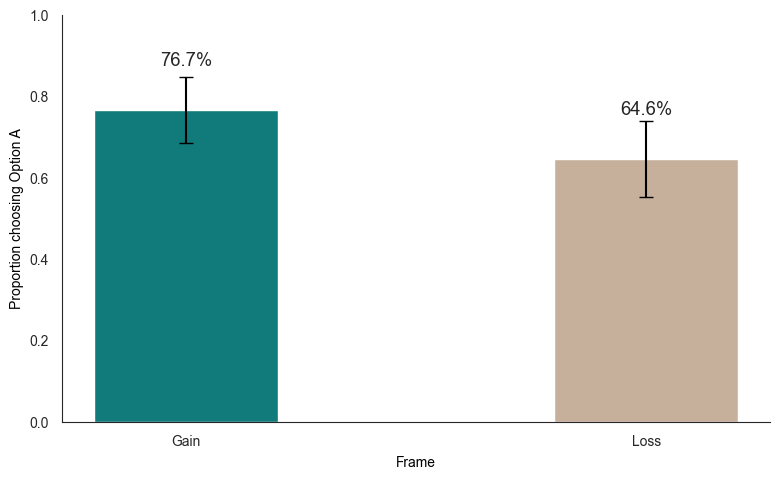

In [25]:
##GraphProportion Choosing Option A by Frame 

agg_data = main_analysis.groupby(['frame']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()

agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']

plt.figure(figsize=(8, 5))

##palette = ['#C1CDCD', '#CDAF95', '#008B8B']

palette = {'Gain': '#008B8B', 'Loss': '#CDAF95'}

bars = sns.barplot(data=agg_data, x='frame', y='prop_A_mean', palette=palette, width = .4 ) ##, capsize=0.05) ##, width = 0.4)
bars.set_xticklabels(labels = ['Gain', 'Loss' ], rotation = 0, fontsize=10)
for i, bar in enumerate(bars.patches):
    yval = bar.get_height()
    yerr = agg_data['conf_int'].iloc[i]
    bars.text(bar.get_x() + bar.get_width() / 2, yval + 0.1,
              '{:.1%}'.format(yval), ha='center', va='bottom') 
    bars.errorbar(x=bar.get_x() + bar.get_width() / 2, y=yval,
                 yerr=yerr, color='black', capsize=5, fmt='none', elinewidth=1.5)

sns.despine()
plt.ylabel('Proportion choosing Option A', fontsize = 10)
plt.xlabel('Frame', labelpad = 5, fontsize = 10)
bars.set_yticks([0,.2,.4,.6,.8,1])
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
fig = bars.get_figure()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/figures/propA_frame.png")


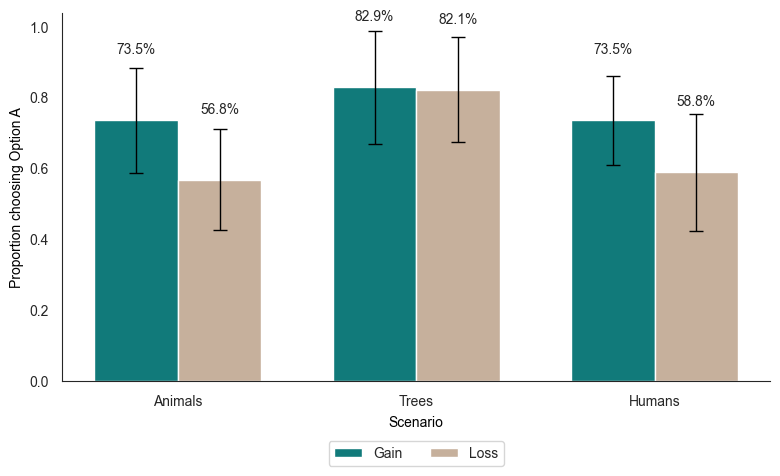

In [26]:
##GraphProportion Choosing Option A by Scenario 

agg_data = main_analysis.groupby(['scenario_clean', 'frame']).option_selected.agg(
    prop_A_mean = lambda x: np.mean(x == "Proposal A"),
    prop_A_std = lambda x: np.std(x == "Proposal A") / np.sqrt(len(x))
).reset_index()

agg_data['conf_int'] = 1.96 * agg_data['prop_A_std']

#order of bars
order = ['animals', 'forest', 'humans']
agg_data['scenario_clean'] = pd.Categorical(agg_data['scenario_clean'], categories=order, ordered=True)
agg_data = agg_data.sort_values('scenario_clean')

plt.figure(figsize=(8, 5))
palette = {'Gain': '#008B8B', 'Loss': '#CDAF95'}
bars = sns.barplot(data=agg_data, x='scenario_clean', y='prop_A_mean', hue='frame', palette=palette, width = .7 ) 
bars.set_xticklabels(labels = ['Animals', 'Trees', 'Humans' ], rotation = 0, fontsize=10)
for i, bar in enumerate(bars.patches):
    yval = bar.get_height()
    yerr = agg_data['conf_int'].iloc[i]
    bars.text(bar.get_x() + bar.get_width() / 2, yval + 0.18,
              '{:.1%}'.format(yval), ha='center', va='bottom', fontsize=10) 
    bars.errorbar(x=bar.get_x() + bar.get_width() / 2, y=yval,
                 yerr=yerr, color='black', capsize=5, fmt='none', elinewidth=1)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

change_width(bars, .35)
sns.despine()
plt.ylabel('Proportion choosing Option A', fontsize = 10)
plt.xlabel('Scenario', labelpad = 5, fontsize = 10)
bars.set_yticks([0,.2,.4,.6,.8,1])
plt.yticks(fontsize=10)
plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=10)
plt.tight_layout()
plt.show()
fig = bars.get_figure()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/figures/propA_scn_frame.png")


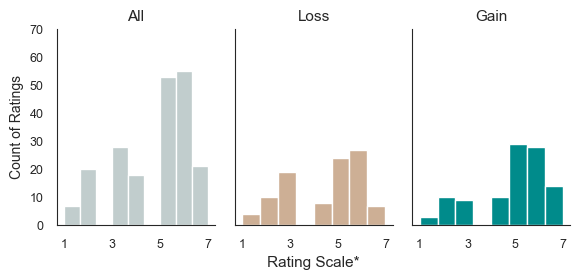

In [659]:
##Histogram Of Reversed Rating Num, Frame 
fig, axes = plt.subplots(1, 3, figsize=(6, 3), sharey=True)  # Changed figsize to make the figure taller
plt.subplots_adjust( wspace=.25, hspace=.5)
colors = ['#C1CDCD', '#CDAF95', '#008B8B']

sns.histplot(data=main_analysis, x='reversed_rating_num', ax=axes[0], color= colors[0], edgecolor="w", alpha=1)
axes[0].set_title('All', fontsize=11)
axes[0].set_xlabel('')
axes[0].set_xticks(np.arange(1,7))
axes[0].set_xticks([1,3,5,7])
axes[0].set_ylabel('Count of Ratings', fontsize=10)
axes[0].set_yticks([0,10,20,30,40,50,60,70])
axes[0].tick_params(axis='both', labelsize=9)

sns.histplot(data=loss_condition, x='reversed_rating_num', ax=axes[1], color= colors[1],  edgecolor="w", alpha =1)
axes[1].set_title('Loss', fontsize=11)
axes[1].set_xlabel('Rating Scale*', fontsize=11)
axes[1].set_xticks([1,3,5,7])
axes[1].set_yticks([0,10,20,30,40,50,60,70])
axes[1].tick_params(axis='both', labelsize=9)

sns.histplot(data=gain_condition, x='reversed_rating_num', ax=axes[2], color= colors[2],  edgecolor="w", alpha=1)
axes[2].set_title('Gain', fontsize=11)
axes[2].set_xlabel('')
axes[2].set_xticks([1,3,5,7])
axes[2].set_yticks([0,10,20,30,40,50,60,70])
axes[2].tick_params(axis='both', labelsize=9)
sns.despine()
plt.tight_layout()
plt.show()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/figures/rating_frame.png")

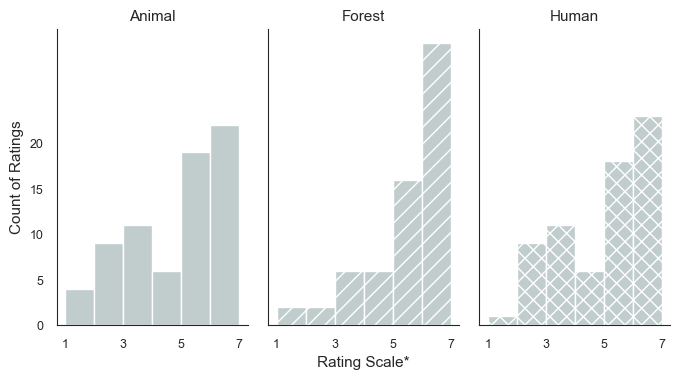

In [657]:
##Histogram Of Reversed Rating Num, Scenario & Frame (All)

loss_for = forest[forest['frame'] == 'Loss']
loss_an = animal[animal['frame'] == 'Loss']
loss_hum = human[human['frame'] == 'Loss']

gain_for = forest[forest['frame'] == 'Gain']
gain_an = animal[animal['frame'] == 'Gain']
gain_hum = human[human['frame'] == 'Gain']

colors = ['#C1CDCD']
fig, axes = plt.subplots(1, 3, figsize=(7, 4), sharey=True)

datasets = [animal, forest, human]
hatches = [None, '//', 'xx']  # None for animal, '//' for forest, and 'xx' for human

# plot bars
for i, data in enumerate(datasets):
    plot = sns.histplot(data=data, x='reversed_rating_num', ax=axes[i], color='#C1CDCD', edgecolor="w", alpha=1, binwidth=1) 
    axes[i].set_xticks([1,3,5,7])
    axes[i].tick_params(axis='both', labelsize=9)
    axes[i].set_ylabel("Count of Ratings", fontsize=11)
    if i == 1:
        axes[i].set_xlabel("Rating Scale*", fontsize=11)
    else: 
        axes[i].set_xlabel("")
    if i == 0:
        axes[i].set_title("Animal", fontsize=11)
    elif i == 1: 
        axes[i].set_title("Forest", fontsize=11)
    else:
        axes[i].set_title("Human", fontsize=11)
    axes[i].set_yticks([0,5,10,15,20])

    # Apply hatch if it's not None
    if hatches[i] is not None:
        for bar in axes[i].patches:
            bar.set_hatch(hatches[i])
plt.tight_layout()
sns.despine()
plt.show()
fig = plot.get_figure()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/figures/raiting_scn_All.png")



In [1]:
##Histogram Of Reversed Rating Num, Scenario & Frame (Gain)
fig, axes = plt.subplots(1, 3, figsize=(7, 4), sharey=True)

datasets = [gain_an, gain_for, gain_hum]
hatches = [None, '//', 'xx']  # None for animal, '//' for forest, and 'xx' for human

# plot bars
for i, data in enumerate(datasets):
    plot = sns.histplot(data=data, x='reversed_rating_num', ax=axes[i], color='#008B8B', edgecolor="w", alpha=1, binwidth=1) 
    axes[i].set_xticks([1,3,5,7])
    axes[i].tick_params(axis='both', labelsize=9)
    axes[i].set_ylabel("Count of Ratings", fontsize=11)
    if i == 1:
        axes[i].set_xlabel("Rating Scale*", fontsize=11)
    else: 
        axes[i].set_xlabel("")
    if i == 0:
        axes[i].set_title("Animals", fontsize=11)
    elif i == 1: 
        axes[i].set_title("Trees", fontsize=11)
    else:
        axes[i].set_title("Humans", fontsize=11)
    axes[i].set_yticks([0,5,10,15,20])

    # Apply hatch if it's not None
    if hatches[i] is not None:
        for bar in axes[i].patches:
            bar.set_hatch(hatches[i])
plt.tight_layout()
sns.despine()
plt.show()
fig = plot.get_figure()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/figures/raiting_scn_gain.png")


NameError: name 'plt' is not defined

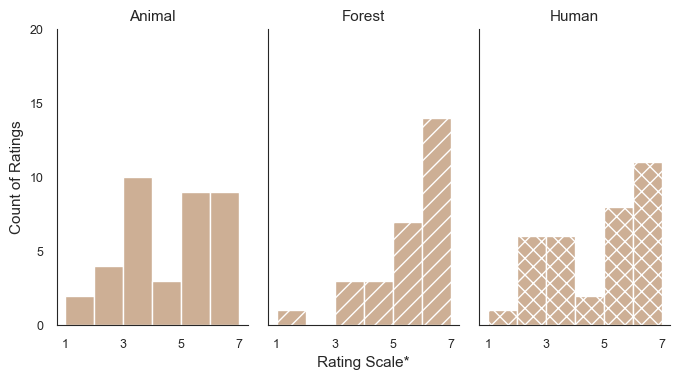

In [807]:
##Histogram Of Reversed Rating Num, Scenario & Frame (Loss)
fig, axes = plt.subplots(1, 3, figsize=(7, 4), sharey=True)

datasets = [loss_an, loss_for, loss_hum]
hatches = [None, '//', 'xx']  

# plot bars
for i, data in enumerate(datasets):
    plot = sns.histplot(data=data, x='reversed_rating_num', ax=axes[i], color='#CDAF95', edgecolor="w", alpha=1, binwidth=1) 
    axes[i].set_xticks([1,3,5,7])
    axes[i].tick_params(axis='both', labelsize=9)
    axes[i].set_ylabel("Count of Ratings", fontsize=11)
    if i == 1:
        axes[i].set_xlabel("Rating Scale*", fontsize=11)
    else: 
        axes[i].set_xlabel("")
    if i == 0:
        axes[i].set_title("Animals", fontsize=11)
    elif i == 1: 
        axes[i].set_title("Trees", fontsize=11)
    else:
        axes[i].set_title("Humans", fontsize=11)
    axes[i].set_yticks([0,5,10,15,20])
    if hatches[i] is not None:
        for bar in axes[i].patches:
            bar.set_hatch(hatches[i])
plt.tight_layout()
sns.despine()
plt.show()
fig = plot.get_figure()
fig.savefig("raiting_scn_loss.png")
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/figures/raiting_scn_loss.png")

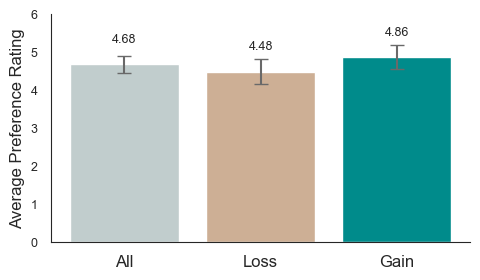

In [655]:
##Plot graph for average rating by condition 
values = np.array([main_analysis.reversed_rating_num.mean(), loss_condition.reversed_rating_num.mean(), gain_condition.reversed_rating_num.mean(), ])
se = np.array([main_analysis.reversed_rating_num.std(), loss_condition.reversed_rating_num.std(), gain_condition.reversed_rating_num.std()]) / np.sqrt([len(main_analysis), len(loss_condition), len(gain_condition)])
yerrs = 1.96 * se

#plot
palette = ['#C1CDCD', '#CDAF95', '#008B8B']
plt.figure(figsize=(5, 3))
bars = plt.bar(np.arange(3), values, yerr=yerrs, color=palette, alpha=1, capsize=5, ecolor='dimgrey') 
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, '{:.2f}'.format(yval), ha='center', va='bottom', fontsize=9)
sns.despine()
plt.ylabel('Average Preference Rating', fontsize=12)
plt.yticks([0,1,2,3,4,5,6], fontsize=9)
plt.xticks(np.arange(3), ['All', 'Loss', 'Gain'], rotation='horizontal', fontsize=12)
plt.tick_params(axis='y', labelsize=9)
plt.tight_layout()
plt.show()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/figures/avgratingbycondition.png")



In [27]:
##Plot graph for average rating by condition 

#forest
values_for = np.array([forest.reversed_rating_num.mean(), loss_for.reversed_rating_num.mean(), gain_for.reversed_rating_num.mean(), ])
se_for = np.array([forest.reversed_rating_num.std(), loss_for.reversed_rating_num.std(), gain_for.reversed_rating_num.std()]) / np.sqrt([len(forest), len(loss_for), len(gain_for)])
yerrs_for = 1.96 * se_for
#animal
values_an = np.array([animal.reversed_rating_num.mean(), loss_an.reversed_rating_num.mean(), gain_an.reversed_rating_num.mean(), ])
se_an = np.array([animal.reversed_rating_num.std(), loss_an.reversed_rating_num.std(), gain_an.reversed_rating_num.std()]) / np.sqrt([len(animal), len(loss_an), len(gain_an)])
yerrs_an = 1.96 * se_an

#humans
values_hum = np.array([human.reversed_rating_num.mean(), loss_hum.reversed_rating_num.mean(), gain_hum.reversed_rating_num.mean(), ])
se_hum = np.array([human.reversed_rating_num.std(), loss_hum.reversed_rating_num.std(), gain_hum.reversed_rating_num.std()]) / np.sqrt([len(human), len(loss_hum), len(gain_hum)])
yerrs_hum = 1.96 * se_hum

palette = ['#C1CDCD', '#CDAF95', '#008B8B']
fig, axes = plt.subplots(1, 3, figsize=(9.5, 3), sharey=True)

bars_for = axes[0].bar(np.arange(3), values_for, yerr=yerrs_for, color=palette, alpha=1, capsize=3, ecolor='dimgrey')
axes[0].set_title('Trees', fontsize=11,y=1.06)
axes[0].set_xticks(np.arange(3))
axes[0].set_xticklabels(['All', 'Loss', 'Gain'], rotation='horizontal', fontsize=10)
bars_for[0].set_hatch('//')

bars_an = axes[1].bar(np.arange(3), values_an, yerr=yerrs_an, color=palette, alpha=1, capsize=3, ecolor='dimgrey')
axes[1].set_title('Animals', fontsize=11,y=1.06)
axes[1].set_xticks(np.arange(3))
axes[1].set_xticklabels(['All', 'Loss', 'Gain'], rotation='horizontal', fontsize=10)
bars_an[0].set_hatch('//')

bars_hum = axes[2].bar(np.arange(3), values_hum, yerr=yerrs_hum, color=palette, alpha=1, capsize=3,ecolor='dimgrey')
axes[2].set_title('Humans', fontsize=11,y=1.06)
axes[2].set_xticks(np.arange(3))
axes[2].set_xticklabels(['All', 'Loss', 'Gain'], rotation='horizontal', fontsize=10)
bars_hum[0].set_hatch('//')
for ax in axes:
    ax.set_yticks(np.arange(0, 7))
    ax.tick_params(axis='both', labelsize=10)
for ax, bars in zip(axes, [bars_for, bars_an, bars_hum]):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.65, '{:.2f}'.format(yval), ha='center', va='bottom', fontsize=9)

sns.despine()
fig.text(.07, 0.5, 'Average Rating Number*', va='center', rotation='vertical', fontsize=10)
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/figures/propA_ratingnum_scn.png")
plt.show()


NameError: name 'loss_for' is not defined

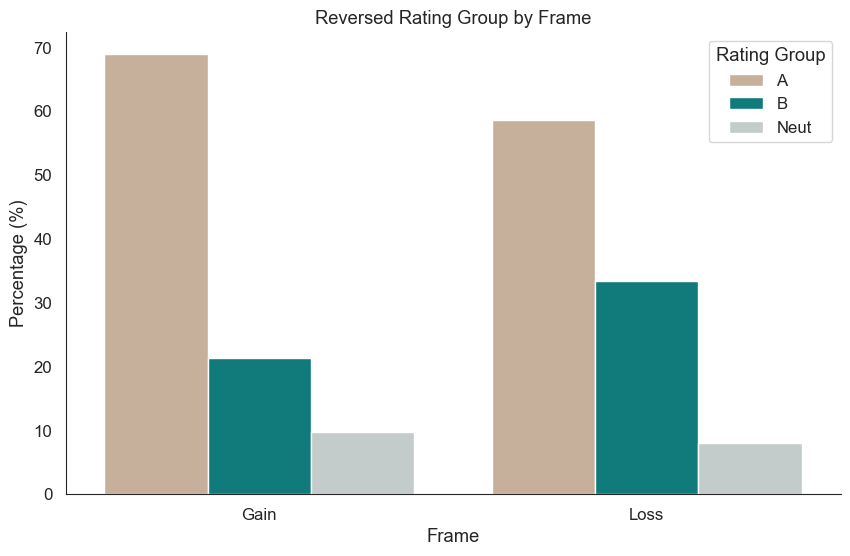

In [822]:
## Bar Graph of Rating Num by Grouping & Frame
pd.crosstab( index = main_analysis['reversed_rating_num'], columns = main_analysis['frame'], margins = True)
rat_group_dict = {'pref A': [5,6,7], 'pref B': [1,2,3], 'Neut': [4]}

main_analysis['reversed_rating_group'] = main_analysis['reversed_rating_num'].apply(
    lambda x: 'A' if x in rat_group_dict['pref A'] else ('B' if x in rat_group_dict['pref B'] else 'Neut')
)

dat = pd.crosstab(
    index=main_analysis['reversed_rating_group'], 
    columns=main_analysis['frame'], 
    margins=True, 
    normalize='columns'
).multiply(100).round(2).reset_index()  # Convert proportions to percentages

dat_melted = dat.melt(id_vars='reversed_rating_group', value_vars=['Gain', 'Loss'])  # Excluding 'All' since it's a summary

palette = [ '#CDAF95', '#008B8B', '#C1CDCD',]
plt.figure(figsize=(10, 6))

# Set 'frame' as x-axis and group by 'reversed_rating_group' using hue
sns.barplot(x='frame', y='value', hue='reversed_rating_group', data=dat_melted, palette=palette)

plt.ylabel('Percentage (%)')
plt.xlabel('Frame')  
plt.title('Reversed Rating Group by Frame')
plt.legend(title='Rating Group') 
sns.despine()
plt.show()

fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/figures/rating_groups.png")



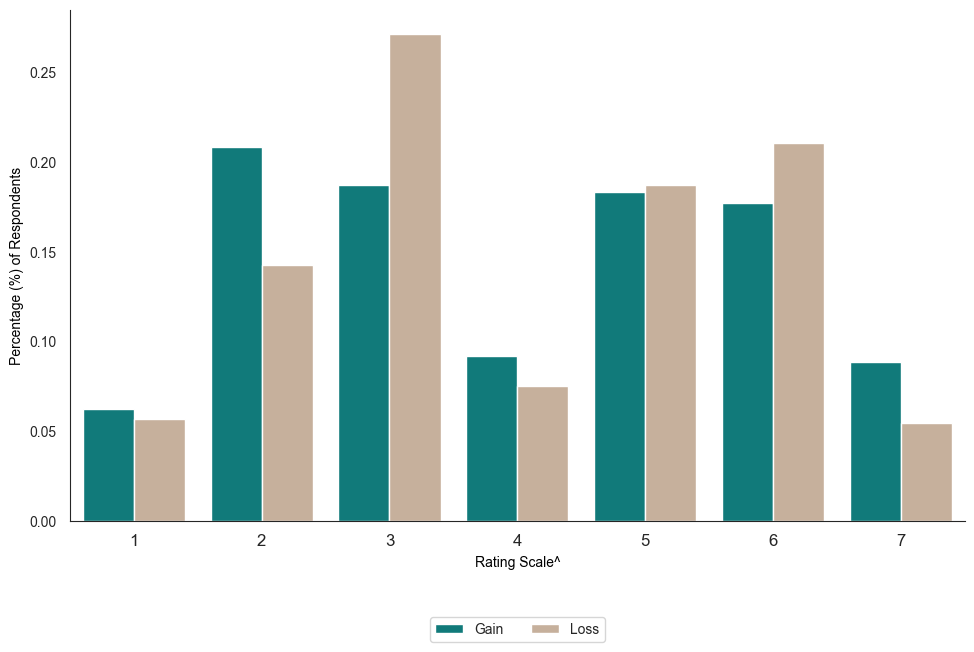

In [28]:
## Bar Graph % Selectig Each Rating

dat = pd.crosstab(
    index=main_analysis['reversed_rating_num'], 
    columns=[main_analysis['frame'], main_analysis['option_selected']],
    normalize='columns',
).round(4).reset_index()

df = pd.DataFrame(dat)

palette = ['#008B8B', '#CDAF95', '#C1CDCD']


# plotting
plt.figure(figsize=(10, 6))
bars = sns.barplot(data=df.melt(id_vars='reversed_rating_num', var_name='Condition', value_name='Proportion'),
            x='reversed_rating_num', y='Proportion', hue='Condition', palette = palette,errorbar=None)
plt.ylabel('Percentage (%) of Respondents', fontsize = 10)
plt.xlabel('Rating Scale^', labelpad = 5, fontsize = 10)
sns.despine()
plt.tight_layout()
plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=10)
#bars.set_yticks([0,.2,.4])
plt.yticks(fontsize=10)
plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize=10)
fig = bars.get_figure()
fig.savefig("/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/figures/ratingnumbarchart%.png")
plt.show()



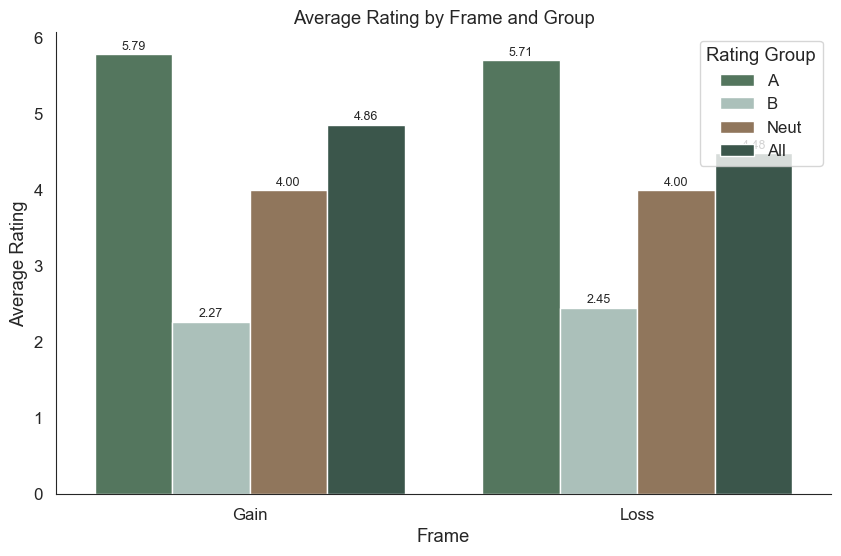

In [863]:
##Rating Count by Groupings 
dat = pd.crosstab(
    index=main_analysis['reversed_rating_group'], 
    columns=main_analysis['frame'], 
    values=main_analysis['reversed_rating_num'],
    aggfunc='mean',
    margins=True
).round(4).reset_index()

dat_melted = dat.melt(id_vars='reversed_rating_group', value_vars=['Gain', 'Loss'])  # Excluding 'All' since it's a summary

palette_earthy = [ "#4E7C5B", "#A8C3BC", "#987654", "#365A4C", "#517C91","#6B4226"]

plt.figure(figsize=(10, 6))
bars = sns.barplot(x='frame', y='value', hue='reversed_rating_group', data=dat_melted, palette=palette_earthy)
for bar in bars.patches:
    yval = bar.get_height()
    bars.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, '{:.2f}'.format(yval), ha='center', va='bottom', fontsize=9)

sns.despine()
plt.legend(title='Rating Group')
plt.xlabel('Frame')
plt.ylabel('Average Rating')
plt.title('Average Rating by Frame and Group')
plt.show()


##### Manipulation / Attention Tests

In [919]:
#look where rationale answer is not null 
rationale_notnull = main_analysis[~main_analysis['rationale'].isna()]
###rationale_cross = pd.crosstab( rationale_notnull['frame'],rationale_notnull['option_selected'], normalize='index')
rationale_cross = pd.crosstab( rationale_notnull['option_selected'],rationale_notnull['frame'], normalize='columns')

print("Breakdown when Rationale answer is not null")
print(f"""Sample Size: {rationale_notnull.shape[0]}""")
print(f"""Gain Sample Size: {rationale_notnull[rationale_notnull['frame'] == 'gain'].shape[0]}""")
print(f"""Loss Sample Size: {rationale_notnull[rationale_notnull['frame'] == 'loss'].shape[0]}""")
rationale_cross

Breakdown when Rationale answer is not null
Sample Size: 167
Gain Sample Size: 0
Loss Sample Size: 0


frame,Gain,Loss
option_selected,,
Proposal A,0.775281,0.551282
Proposal B,0.224719,0.448718


#### Hypotheses Tests

- H1: Human participants will exhibit the framing effect such that in the gain frame, they will be risk-averse (prefer the certain option) and in the loss frame, they will be risk-seeking (prefer the risky option).
    -  H1.1: Human participants will be more likely to choose the certain option (Proposal A) when the scenario is framed as a gain than when it's framed as a loss.
    - H1.2: The strength of preference, as indicated by 'rating_num', will vary depending on whether the scenario is framed as a gain or loss.
- H2: The type of scenario (trees, humans, or animals) will influence the strength of the framing effect in human participants.

##### Set-up variables 

In [31]:
#function for signficance 
def sig_effect(pvalue):
    if pvalue <= .01:
        return f"""significant at 1% level"""
    elif pvalue <= .05:
        return f"""significant at 5% level"""
    elif pvalue <= .1:
        return f"""significant at 10% level"""
    else:
        return "not significant"


##### Hypothesis Testing (Stat Tests)


- H1.1: Human participants will be more likely to choose the certain option (Proposal A) when the scenario is framed as a gain than when it's framed as a loss.
- H1.2: The strength of preference, as indicated by 'rating_num', will vary depending on whether the scenario is framed as a gain or loss.

In [932]:
###H1: Chi-squared Test (or Fisher's Exact Test) for Option Selected:
contingency_table = pd.crosstab(main_analysis['frame'], main_analysis['option_selected'])
chi2, pval, _, _ = stats.chi2_contingency(contingency_table)

contingency_table2 = pd.crosstab(rationale_incl['frame'], rationale_incl['option_selected'])
chi2_2, pval_2, _, _ = stats.chi2_contingency(contingency_table2)

###Output as a table
results_h1 = {
    ('option selected'): {
        'chi2/stat': round(chi2,3),
        'p_val': round(pval,3),
        'sig effect': pval < .05
    },
    ('option selected_2'): {
        'chi2/stat': round(chi2_2,3),
        'p_val': round(pval_2,3),
        'sig effect': pval_2 < .05
    }}




df_hyp_test = pd.DataFrame.from_dict(results_h1)
df_hyp_test



,option selected,option selected_2
chi2/stat,2.988,8.456
p_val,0.084,0.004
sig effect,False,True


In [ ]:
###H2: Kruskal-Wallis Test for Rating ##CHECK ##Reversed Number 
stat, p_val = stats.mannwhitneyu(main_analysis[main_analysis['frame']=='Gain']['reversed_rating_num'], main_analysis[main_analysis['frame']=='Loss']['reversed_rating_num'])
###Output as a table
results = {
    ('option selected'): {
        'chi2/stat': chi2,
        'p_val': pval,
        'sig effect': pval < .05
    },
    ('rating number'): {
        'chi2/stat': stat,
        'p_val': p_val2,
        'sig effect': p_val2 < .05
    }}

In [800]:
##Odds Ratio for Choice Selection
table = sm.stats.Table.from_data(rating_appr[['frame', 'option_selected']])
rslt = table.test_nominal_association()
print(table.local_oddsratios)
#print( rslt.pvalue )


option_selected  Proposal A  Proposal B
frame                                  
gain                1.80013         NaN
loss                    NaN         NaN


##### Robustness Check (Linear)

In [34]:
#-- Simple Linear Regression -- #

##Rating Appr
lin_ratingappr = sm.OLS.from_formula('rating_num ~ frame_gain', data = rating_appr).fit()

##Rating Appr Rationale
lin_ratingappr_rat = sm.OLS.from_formula('rating_num ~ frame_gain', data = rating_appr_rat).fit()

#-- Multiple Linear Regression -- #

# Rating Appr with basic demographic controls 
#lin_dem = sm.OLS.from_formula('rating_num ~ frame + scenario_clean + age_num + gender_num + ethnicity_num + education_num', data = main_analysis).fit()

# Rating Appr  Rat with basic demographic controls 
l#in_dem = sm.OLS.from_formula('rating_num ~ frame + scenario_clean + age_num + gender_num + ethnicity_num + education_num', data = main_analysis).fit()

NameError: name 'l' is not defined

##### Logistic Regression

In [118]:
########## Simple Model ##########

########## 8/8 Version  ##########
##rating_appr
logit_ratingappr = smf.logit('option_selected_A ~ frame_gain', rating_appr).fit()
print("frame coeff:", logit_ratingappr.params[1]) #frame coeff: 0.5878590002488179
print("frame p-vale:", logit_ratingappr.pvalues[1]) #frame p-vale: 0.06108608807922693
print(f"Odds Ratio: {np.exp(logit_ratingappr.params[1])}") #1.8001302083333337
print("\nsignficicant effect? --> ", sig_effect(logit_ratingappr.pvalues[1])) #significant at 10% level
print(logit_ratingappr.summary())  #observations: 202 

##rating_appr_rat 
logit_reg_rating_rat = smf.logit('option_selected_A ~ frame_gain', rating_appr_rat).fit()
print("frame coeff:", logit_reg_rating_rat.params[1]) #frame coeff: 1.0325221768391197
print("frame p-vale:", logit_reg_rating_rat.pvalues[1]) #frame p-vale: 0.0024665370461273723
print("\nsignficicant effect? --> ", sig_effect(logit_reg_rating_rat.pvalues[1])) ##significant at 1% level
print(logit_reg_rating_rat.summary())  #observations: 167

#Rating_appr - Gain condition only 
logit_ratingappr_gain = smf.logit('option_selected_A ~ 1', gain_condition_rating).fit()
print(logit_ratingappr_gain.summary()) 

#Rating_appr rat - Gain condition only 
logit_ratingappr_rat_gain = smf.logit('option_selected_A ~ 1', gain_condition_rating_rat).fit()
print(logit_ratingappr_rat_gain.summary()) 

#Rating_appr - Loss condition only 
logit_ratingappr_loss = smf.logit('option_selected_B ~ 1', loss_condition_rating).fit()
print(logit_ratingappr_loss.summary()) 

#Rating_appr rat - Loss condition only 
logit_ratingappr_rat_loss = smf.logit('option_selected_B ~ 1', loss_condition_rating_rat).fit()
print(logit_ratingappr_rat_loss.summary()) 


##"Intercept: 0.6286": This is the log-odds of choosing Proposal A when frame_gain is 0 (i.e., when the scenario is framed as a loss). The coefficient is significantly different from zero at the 1% level (p=0.004).
#frame_gain: 0.6035": This is the change in the log-odds of choosing Proposal A for a one-unit change in frame_gain. Since frame_gain is a binary variable (0 or 1), this change is the difference in log-odds between a gain and a loss frame. A positive coefficient suggests that when the scenario is framed as a gain, the log-odds of choosing Proposal A increase.

######### ---- Create Tables ---- ######### 

#Create tables for Simple 
from tabulate import tabulate

## function for 'frame_gain' regressions 
def get_summary_stats(model):
    p_val = model.pvalues['frame_gain']
    conf_interval = f"{round(model.conf_int().loc['frame_gain', 0], 3)} - {round(model.conf_int().loc['frame_gain', 1], 3)}"
    if p_val < 0.01:
        asterisks = '***'
    elif p_val < 0.05:
        asterisks = '**'
    elif p_val < 0.10:
        asterisks = '*'
    else:
        asterisks = ''
    return {
        'Frame (Gain)': f"{round(model.params['frame_gain'],3)} ({round(model.bse['frame_gain'],3)})",
        'Constant': f"{round(model.params['Intercept'],3)} ({round(model.bse['Intercept'],3)})",
        'P-value': f"{round(p_val,3)}{asterisks}",
        'Confidence Interval': conf_interval, 
        'Odds Ratio': round(np.exp(model.params['frame_gain']),4),
        'Observations ':model.nobs,
        'Pseudo R^2': round(model.prsquared,3)

    }

## function for 'intercept' regressions 
def intercept_summary(model):
    p_val = model.pvalues['Intercept']
    conf_interval = f"{round(model.conf_int().loc['Intercept', 0], 3)} - {round(model.conf_int().loc['Intercept', 1], 3)}"
    if p_val < 0.01:
        asterisks = '***'
    elif p_val < 0.05:
        asterisks = '**'
    elif p_val < 0.10:
        asterisks = '*'
    else:
        asterisks = ''
    return {
        'Constant': f"{round(model.params['Intercept'],3)} ({round(model.bse['Intercept'],3)})",
        'std_err' : round(model.bse['Intercept'],3),
        'p value': f"{round(p_val,3)}{asterisks}",
        'conf_interval': conf_interval, 
        'Odds Ratio': round(np.exp(model.params['Intercept']),3),
        'n': round(model.nobs,3),
        'Pseudo R^2': round(model.prsquared,3)

    }

###table for Simple Comparison 
summary_stats_logit_v1 = [get_summary_stats(logit_ratingappr),
                          get_summary_stats(logit_reg_rating_rat)]
summary_logit_df1 = pd.DataFrame(summary_stats_logit_v1)
summary_logit_df1.T

table1 = summary_logit_df1.T
basic_models = summary_logit_df1.T
print(basic_models)
basic_models.to_csv('basic_models.csv', index=False)

##table for gain / loss Comparison 
summary_options = [intercept_summary(logit_ratingappr_gain), 
                 intercept_summary(logit_ratingappr_rat_gain),
                 intercept_summary(logit_ratingappr_loss),
                 intercept_summary(logit_ratingappr_rat_loss)                 
                 ]
summary_options_df = pd.DataFrame(summary_options)

options_tables = summary_options_df.T
##print('\n')
##print(tabulate(options_tables, tablefmt = 'pretty', headers=["variable", "Gain Condition - All", "Gain Condition - Rationale Only","Loss Condition - All", "Loss Condition - Rationale Only" ]))
options_tables.to_csv('options_tables.csv')
basic_models

Optimization terminated successfully.
         Current function value: 0.595191
         Iterations 5
frame coeff: 0.5878590002488179
frame p-vale: 0.06108608807922693
Odds Ratio: 1.8001302083333337

signficicant effect? -->  significant at 10% level
                           Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                  202
Model:                          Logit   Df Residuals:                      200
Method:                           MLE   Df Model:                            1
Date:                Sun, 27 Aug 2023   Pseudo R-squ.:                 0.01459
Time:                        14:49:47   Log-Likelihood:                -120.23
converged:                       True   LL-Null:                       -122.01
Covariance Type:            nonrobust   LLR p-value:                   0.05919
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

,0,1
Frame (Gain),0.588 (0.314),1.033 (0.341)
Constant,0.604 (0.21),0.206 (0.228)
P-value,0.061*,0.002***
Confidence Interval,-0.027 - 1.203,0.364 - 1.701
Odds Ratio,1.8001,2.8081
Observations,202,167
Pseudo R^2,0.015,0.045


In [38]:
##for power analysis 
predicted_probs = logit_ratingappr_gain.predict(gain_condition_rating)
odds = round(np.exp(logit_ratingappr_gain.params['Intercept']),4)# Average of these predicted probabilities will give Pr(Y=1|X=1)
prob_Y1_given_X1 = np.mean(predicted_probs)
prob_Y1_given_X1
pi_value = len(gain_condition_rating) / len(rating_appr)
pi_value
print(odds)

##caveat that too low for gain version

predicted_probs2 = logit_ratingappr.predict(rating_appr)
odds2 = round(np.exp(logit_ratingappr.params['frame_gain']),4)# Average of these predicted probabilities will give Pr(Y=1|X=1)
prob_Y1_given_X1_2 = np.mean(predicted_probs2)
print(prob_Y1_given_X1_2)
#pi_value = len(gain_condition_rating) / len(rating_appr)
print(odds2)

3.2917
0.7079207920792079
1.8001


In [ ]:
##Plotting Residuals

import matplotlib.pyplot as plt
%matplotlib inline

# Deviance residuals
deviance_residuals = logit_ratingappr.resid_dev

# Plot
plt.plot(deviance_residuals)
plt.show()


In [ ]:
##########  ADP Versions ##########

########## 8/8 ##########
#ating Appr
logit_ADPNo_ratingappr = smf.logit('option_selected_A ~ frame_gain + C(ADP_No)', rating_appr).fit()
print("frame coeff:", logit_ADPNo_ratingappr.params[2])  #frame coeff: frame coeff: 0.6305057083048329
print("frame p-vale:", logit_ADPNo_ratingappr.pvalues[2]) #frame p-vale:  0.04767859296463091
print("ADP coeff:", logit_ADPNo_ratingappr.params[1])  # coeff: frame coeff: -0.11247583550477258
print("ADP p-vale:", logit_ADPNo_ratingappr.pvalues[1]) # p-vale:  0.7229922428617646
print("\nsignficicant effect? --> ", sig_effect(logit_ADPNo_ratingappr.pvalues[2])) #significant at 5% level
print(logit_ADPNo_ratingappr.summary())
#coefficient is -0.1124, suggesting that being familiar with ADP -> to a decrease in the log odds of selecting Proposal A

#Rating Appr Rat
logit_ADPNo_ratingappr_rat = smf.logit('option_selected_A ~ frame_gain + C(ADP_No)', rating_appr_rat).fit()
print("frame coeff:", logit_ADPNo_ratingappr_rat.params[2])  #frame coeff: frame coeff: 1.0818773551539747
print("frame p-vale:", logit_ADPNo_ratingappr_rat.pvalues[2]) #frame p-vale:  0.0018309528592363926
print("ADP coeff:", logit_ADPNo_ratingappr_rat.params[1])  # coeff: frame coeff: 0.12954604771423606
print("ADP p-vale:", logit_ADPNo_ratingappr_rat.pvalues[1]) # p-vale:  0.7076142556285303
print("\nsignficicant effect? --> ", sig_effect(logit_ADPNo_ratingappr_rat.pvalues[2]))  #significant at 1% level
print(logit_ADPNo_ratingappr_rat.summary())
#coefficient is -0.1124, suggesting that being familiar with ADP -> to a decrease in the log odds of selecting Proposal A

##Rating Appr Rat with ADP excluded
logit_reg_noADP = smf.logit('option_selected_A ~ frame_gain', rating_appr_noADP).fit()  ##1 = Prop A, 0 = Prop B
print("\Simple Model with No ADP Familarity")
print("frame coeff:", logit_reg_noADP.params[1]) #1.156309277988964
print("frame p-vale:", logit_reg_noADP.pvalues[1]) #0.010706997573492305
print("\nsignficicant effect? --> ", sig_effect(logit_reg_noADP.pvalues[1])) #significant at 5% level
#print(logit_reg_noADP.summary())

##Rating Appr Rat with ADP excluded
logit_reg_noADP2 = smf.logit('option_selected_A ~ frame_gain', rating_appr_rat_noADP).fit()  ##1 = Prop A, 0 = Prop B
print("\Simple Model with No ADP Familarity")
print("frame coeff:", logit_reg_noADP2.params[1]) #1.381521082367233
print("frame p-vale:", logit_reg_noADP2.pvalues[1]) #0.003437058838870402
print("\nsignficicant effect? --> ", sig_effect(logit_reg_noADP2.pvalues[1])) #significant at 1% level
#print(logit_reg_noADP2.summary())


######### ---- Create Tables ---- ######### 

#Create tables for ADP 
from tabulate import tabulate


###table for ADP Comparison 
summary_stats_ADP_v1 = [get_summary_stats(logit_ratingappr), 
                 get_summary_stats(logit_ADPNo_ratingappr),
                 get_summary_stats(logit_reg_noADP, )]
summary_ADP_df1 = pd.DataFrame(summary_stats_ADP_v1)
summary_ADP_df1.T


summary_stats_ADP_v2 = [get_summary_stats(logit_reg_rating_rat), 
                 get_summary_stats(logit_ADPNo_ratingappr_rat ),
                 get_summary_stats(logit_reg_noADP2, )]
summary_ADP_df2 = pd.DataFrame(summary_stats_ADP_v2)
summary_ADP_df2.T

ADP_table1 = summary_ADP_df1.T
ADP_table2 = summary_ADP_df2.T
ADP_table1.to_csv("ADP_table1.csv")

#, 'logit_rating', 'ADP_control_rating', 'ADP_notyes_rating'
#'logit_rationale', 'ADP_control_rationale', 'ADP_notyes_rationale'

In [688]:
##########  Scenario Versions ##########

########## 8/8 ##########
#ating Appr
logit_rating_scn = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean)', rating_appr).fit()
print("frame coeff:", logit_rating_scn.params[3])  #frame coeff: frame coeff: 0.557044115663797
print("frame p-vale:", logit_rating_scn.pvalues[3]) #frame p-vale:  0.0802787775635036
print("animals coeff:", logit_rating_scn.params[1])  # coeff: frame coeff: -0.9142439974316887
print("animals p-vale:", logit_rating_scn.pvalues[1]) # p-vale:  0.7229922428617646
print("humans coeff:", logit_rating_scn.params[2])  # coeff: frame coeff: -0.8636220964915821
print("humans p-vale:", logit_rating_scn.pvalues[2]) # p-vale:  0.04079430506839161
print("\nsignficicant effect? --> ", sig_effect(logit_rating_scn.pvalues[3])) #significant at 10% level
print(logit_rating_scn.summary())

#Rating Appr Rat
logit_rating_scn2 = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean)', rating_appr_rat).fit()
print("frame coeff:", logit_rating_scn2.params[3])  #frame coeff: frame coeff: 0.557044115663797
print("frame p-vale:", logit_rating_scn2.pvalues[3]) #frame p-vale: 0.005048574805227938
print("animals coeff:", logit_rating_scn2.params[1])  # coeff: frame coeff: -1.1119886805286159
print("animals p-vale:", logit_rating_scn2.pvalues[1]) # p-vale: 0.012419198230763746
print("humans coeff:", logit_rating_scn2.params[2])  # coeff: frame coeff:-0.8993008344054968
print("humans p-vale:", logit_rating_scn2.pvalues[2]) # p-vale: 0.04273187465875459
print("\nsignficicant effect? --> ", sig_effect(logit_rating_scn2.pvalues[3])) #significant at 1% level
print(logit_rating_scn2.summary())


Optimization terminated successfully.
         Current function value: 0.580189
         Iterations 5
frame coeff: 0.557044115663797
frame p-vale: 0.0802787775635036
animals coeff: -0.9142439974316887
animals p-vale: 0.028531850275997285
humans coeff: -0.8636220964915821
humans p-vale: 0.040794305068391615

signficicant effect? -->  significant at 10% level
                           Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                  202
Model:                          Logit   Df Residuals:                      198
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Aug 2023   Pseudo R-squ.:                 0.03943
Time:                        00:58:21   Log-Likelihood:                -117.20
converged:                       True   LL-Null:                       -122.01
Covariance Type:            nonrobust   LLR p-value:                   0.02208
        

LinAlgError: Singular matrix

In [126]:
logit_reg_dem = smf.logit('option_selected_A ~ frame_gain + C(age_grouped) + C(gender_grouped)+ C(ethnicity) + C(education)', rating_appr).fit()
print("frame coeff:", logit_reg_dem.params[13])  #frame coeff:   0.7271781809222718
print("frame p-vale:", logit_reg_dem.pvalues[13]) #frame p-vale: 0.037323068115545005
print("\nsignficicant effect?", sig_effect(logit_reg_dem.pvalues[13])) #significant at 5% level
print("\n\n\n",logit_reg_dem.summary())

Optimization terminated successfully.
         Current function value: 0.557007
         Iterations 6
frame coeff: -0.9445718039279308
frame p-vale: 0.014715837821316477

signficicant effect? significant at 5% level



                            Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                  202
Model:                          Logit   Df Residuals:                      189
Method:                           MLE   Df Model:                           12
Date:                Sun, 27 Aug 2023   Pseudo R-squ.:                 0.07781
Time:                        14:52:09   Log-Likelihood:                -112.52
converged:                       True   LL-Null:                       -122.01
Covariance Type:            nonrobust   LLR p-value:                   0.08886
                                                                                       coef    std err          z      P>|z|      [0.025      0.975]

In [119]:
########## Controls Version ##########

##Rating Appr with Scenario + basic demographic controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 
logit_reg_dem = smf.logit('option_selected_A ~ frame_gain + C(age) + C(gender)+ C(ethnicity) + C(education)', rating_appr).fit()
print("frame coeff:", logit_reg_dem.params[13])  #frame coeff:   0.7271781809222718
print("frame p-vale:", logit_reg_dem.pvalues[13]) #frame p-vale: 0.037323068115545005
print("\nsignficicant effect?", sig_effect(logit_reg_dem.pvalues[13])) #significant at 5% level
print("\n\n\n",logit_reg_dem.summary())
 
##Rating Appr with Scenario + basic demographic controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 
logit_reg_demb = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity) + C(education)', rating_appr).fit()
print("frame coeff:", logit_reg_demb.params[15])  #frame coeff:   0.7271781809222718
print("frame p-vale:", logit_reg_demb.pvalues[15]) #frame p-vale: 0.037323068115545005
print("\nsignficicant effect?", sig_effect(logit_reg_demb.pvalues[15])) #significant at 5% level
print("\n\n\n",logit_reg_demb.summary())


##Rating Appr with Scenario + all demographic controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 
logit_reg_demall = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity)+ C(education) +  C(continent_grouped) + C(student)', rating_appr).fit()
print("frame coeff:", logit_reg_demall.params[19]) # frame coeff: 0.6773080280922608
print("frame p-vale:", logit_reg_demall.pvalues[19]) #frame p-vale:  0.06050466791136513
print("\nsignficicant effect?", sig_effect(logit_reg_demall.pvalues[19])) #significant at 10% level
logit_reg_demall.summary()

##Rating Appr with all demographic controls + scenario + ADP
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 
logit_reg_conall = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity)+ C(education) +  C(continent_grouped) + C(student) + C(ADP_No)', rating_appr).fit()
print("frame coeff:", logit_reg_conall.params[20]) # frame coeff: .7453067314741395
print("frame p-vale:", logit_reg_conall.pvalues[20]) # frame p-vale: 0.04417210042673677
print("\nsignficicant effect?", sig_effect(logit_reg_conall.pvalues[20])) #significant at 5% level
logit_reg_conall.summary()


################ Rating Appr Rationale ################
##Rating Appr Rationale with Scenario + basic demographic controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 

logit_reg_demb2 = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity) + C(education)', rating_appr_rat).fit()
print("frame coeff:", logit_reg_demb2.params[15])  #frame coeff:  0.7394700819157529
print("frame p-vale:", logit_reg_demb2.pvalues[15]) #frame p-vale: 0.03591022737590693
print("\nsignficicant effect?", sig_effect(logit_reg_demb2.pvalues[15])) #significant at 5% level
print("\n\n\n",logit_reg_demb2.summary())

##Rating Appr Rationale with Scenario + all demographic controls 
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 
logit_reg_demall2 = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity)+ C(education) +  C(continent_grouped) + C(student)', rating_appr_rat).fit()
logit_reg_demall2.summary()

##Rating Appr Rationale with all demographic controls + scenario + ADP
#-- logit regression with basic demographic controls and scenario 
#-- option_selected_rev indicates 0 for B and 1 for A 

logit_reg_conall2 = smf.logit('option_selected_A ~ frame_gain + C(scenario_clean) + C(age) + C(gender)+ C(ethnicity)+ C(education) +  C(continent_grouped) + C(student) + C(ADP_No)', rating_appr_rat).fit()
print("frame coeff:", logit_reg_conall2.params[20]) # frame coeff: 0.7336901911721359
print("frame p-vale:", logit_reg_conall2.pvalues[20]) # frame p-vale: 0.04867989536640349
print("\nsignficicant effect?", sig_effect(logit_reg_conall2.pvalues[20])) #significant at 5% level
logit_reg_conall2.summary()

######### ---- Create Tables ---- ######### 

##Tables for main paper -- models with controls

###table for Control Comparison 
summary_stats_con_v1 = [get_summary_stats(logit_ratingappr), 
               ## get_summary_stats(logit_rating_scn),
                get_summary_stats(logit_reg_dem),
                 get_summary_stats(logit_reg_demb),
               ##  get_summary_stats(logit_reg_demall ),
                 get_summary_stats(logit_reg_conall)]

summary_con_df1 = pd.DataFrame(summary_stats_con_v1)
summary_con_df1.T


summary_stats_con_v2 = [get_summary_stats(logit_reg_rating_rat), 
                 get_summary_stats(logit_reg_demb2),
                 get_summary_stats(logit_reg_demall2 ),
                 get_summary_stats(logit_reg_conall2)]
summary_con_df2 = pd.DataFrame(summary_stats_con_v2)
summary_con_df2.T

controls_tab1 = summary_con_df1.T
controls_tab2 = summary_con_df2.T

print("Rating Appr")
controls_tab1.to_csv('ratingappr_controlscomparison.csv')
#print(tabulate(controls_tab1, headers = ('No Controls','+ Basic Dem', '+ SCN & Basic Demographic', '+ All Controls' ), tablefmt = 'pretty'))
controls_tab1


         Current function value: 0.543632
         Iterations: 35
frame coeff: -0.9354400080162509
frame p-vale: 0.06161673008559678

signficicant effect? significant at 10% level



                            Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                  202
Model:                          Logit   Df Residuals:                      185
Method:                           MLE   Df Model:                           16
Date:                Sun, 27 Aug 2023   Pseudo R-squ.:                 0.09995
Time:                        14:50:01   Log-Likelihood:                -109.81
converged:                      False   LL-Null:                       -122.01
Covariance Type:            nonrobust   LLR p-value:                   0.08133
                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

/Users/annaking/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/annaking/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/annaking/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/annaking/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LinAlgError: Singular matrix

##### ETHNICITY MADDNESS 

In [249]:
pd.crosstab(main_analysis['ethnicity_ord'] , main_analysis['option_selected_A'])

option_selected_A,0,1
ethnicity_ord,,
Asian,10,20
Black/African/Caribbean,8,15
Other,1,1
Prefer not to say,1,1


In [933]:
from sklearn.linear_model import LogisticRegression
df = main_analysis
# X is your predictor variables, and y is your binary outcome
clf_ridge = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
X = df[['frame_gain']]
y = df['option_selected_A']
clf_ridge.fit(X, y)
dir(clf_ridge)


clf_ridge.coef_

array([[0.55955978]])

##### Rating Number (Ordinal)

In [ ]:
####Proportional Odds Assumption

In [84]:
####### Simple (no controls) Ordinal Regressions #####
##### Version 8/8 #####
##frame_rev: 1 = gain, 0 = loss
##frame_gain: 0 = gain, 1 = loss
##rating_num 

##Rating Appr 
ord_logit_ratapp = OrderedModel.from_formula("rating_num ~ 0 + frame_gain ",rating_appr, distr='logit').fit(method='bfgs')
#print("\nrating_appr")
#print("frame coeff:", ord_logit_ratapp.params[0]) #frame coeff: -0.4026162882171143
#print("frame p-vale:", ord_logit_ratapp.pvalues[0]) #frame p-vale: 0.10824411307025375
#print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp.pvalues[0])) #not significant
#print(ord_logit_ratapp.summary())

##rating_appr_rat 
ord_logit_ratapp_rat = OrderedModel.from_formula("rating_num ~ 0 + frame_gain ",rating_appr_rat, distr='logit').fit(method='bfgs')
#print("\nrating_appr_rat")
#print("frame coeff:", ord_logit_ratapp_rat.params[0]) #frame coeff: -0.6553318352976806
#print("frame p-vale:", ord_logit_ratapp_rat.pvalues[0]) #frame p-vale: 0.01854378741043065
#print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rat.pvalues[0])) ##significant at 5% level
#print(ord_logit_ratapp_rat.summary())

############################## --- REVERSING Rating SCALE --- ##############################
##frame_rev or frame_gain: 1 = gain, 0 = loss

##Rating Appr 
ord_logit_ratapp_rev = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_gain ",rating_appr, distr='logit').fit(method='bfgs')
print("\nrating_appr, with reversed rating num")
print("frame coeff:", ord_logit_ratapp_rev.params[0]) #frame coeff:  0.40267782416887127
print("frame p-vale:", ord_logit_ratapp_rev.pvalues[0]) #frame p-vale: 0.1081917719418552
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rev.pvalues[0])) #not significant
print(ord_logit_ratapp_rev.summary())

##rating_appr_rat 
ord_logit_ratapp_rat_rev = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_gain ",rating_appr_rat, distr='logit').fit(method='bfgs')
print("\nrating_appr_rat, with reversed rating num")
print("frame coeff:", ord_logit_ratapp_rat_rev.params[0]) #frame coeff: 0.6553318352976806
print("frame p-vale:", ord_logit_ratapp_rat_rev.pvalues[0]) #frame p-vale: 0.01854378741043065
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rat_rev.pvalues[0])) ##significant at 5% level
print(ord_logit_ratapp_rat_rev.summary())


######## --- Create Tables --- ########

###table for Simple Comparison 

## function for 'frame_gain' regressions 
def get_summary_stats(model):
    p_val = model.pvalues['frame_gain']
    conf_interval = f"{round(model.conf_int().loc['frame_gain', 0], 3)} - {round(model.conf_int().loc['frame_gain', 1], 3)}"
    if p_val < 0.01:
        asterisks = '***'
    elif p_val < 0.05:
        asterisks = '**'
    elif p_val < 0.10:
        asterisks = '*'
    else:
        asterisks = ''
    return {
        'Frame (Gain)': f"{round(model.params['frame_gain'],3)} ({round(model.bse['frame_gain'],3)})",
        'P-value': f"{round(p_val,3)}{asterisks}",
        'Confidence Interval': conf_interval, 
        'Odds Ratio': round(np.exp(model.params['frame_gain']),4),
        'Observations ':model.nobs,
        'Pseudo R^2': round(model.prsquared,3)

    }


summary_stats_ord_v1 = [get_summary_stats(ord_logit_ratapp_rev), 
                 get_summary_stats(ord_logit_ratapp_rat_rev)]
summary_ord_df1 = pd.DataFrame(summary_stats_ord_v1)
summary_ord_df1.T

basic_ordinal = summary_ord_df1.T
basic_ordinal
###print(tabulate(table1, tablefmt = 'pretty', headers=["variable", "All Participants", "Rationale Only"]))

Optimization terminated successfully.
         Current function value: 1.789189
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 1.806356
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 1.789189
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24

rating_appr, with reversed rating num
frame coeff: 0.29591806826358463
frame p-vale: 0.19450125472931012

signficicant effect? -->  not significant
                              OrderedModel Results                             
Dep. Variable:     reversed_rating_num   Log-Likelihood:                -432.98
Model:                    OrderedModel   AIC:                             880.0
Method:             Maximum Likelihood   BIC:                             904.4
Date:          

,0,1
Frame (Gain),0.296 (0.228),0.477 (0.254)
P-value,0.195,0.06*
Confidence Interval,-0.151 - 0.743,-0.021 - 0.974
Odds Ratio,1.3444,1.611
Observations,242,197
Pseudo R^2,0.002,0.005


In [ ]:
####### Scenario Models #####
##### Version 8/8 #####

#Rating Appr 
ord_logit_ratapp_scn= OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(scenario_clean)",rating_appr, distr='logit').fit(method='bfgs')
ord_logit_ratapp_scn.summary()
print("frame coeff:", ord_logit_ratapp_scn.params[2]) #frame coeff: -0.37223733181945245
print("frame p-vale:", ord_logit_ratapp_scn.pvalues[2]) #frame p-vale: 0.13932979613932026
print("scn_animals coeff:", ord_logit_ratapp_scn.params[0]) # coeff: 0.8543537217311111
print("scn_animals p-vale:", ord_logit_ratapp_scn.pvalues[0]) # p-vale: 0.006354326800319145
print("scn_humans coeff:", ord_logit_ratapp_scn.params[1]) # coeff: .6950380028024601
print("scn_humans p-vale:", ord_logit_ratapp_scn.pvalues[1]) # p-vale: 0.0274679915333521
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_scn.pvalues[2])) #not significant
print(ord_logit_ratapp_scn.summary())

#Rating Appr Rat
ord_logit_ratapp_rat_scn= OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(scenario_clean)",rating_appr_rat, distr='logit').fit(method='bfgs')
ord_logit_ratapp_rat_scn.summary()
print("frame coeff:", ord_logit_ratapp_rat_scn.params[2]) #frame coeff: -0.594515184123428
print("frame p-vale:", ord_logit_ratapp_rat_scn.pvalues[2]) #frame p-vale: 0.033675152520790765
print("scn_animals coeff:", ord_logit_ratapp_rat_scn.params[0]) # coeff: 0.9262575959774988
print("scn_animals p-vale:", ord_logit_ratapp_rat_scn.pvalues[0]) # p-vale: 0.0069183948800673484
print("scn_humans coeff:", ord_logit_ratapp_rat_scn.params[1]) # coeff: 0.6372244770565717
print("scn_humans p-vale:", ord_logit_ratapp_rat_scn.pvalues[1]) # p-vale: 0.05785075484928358
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rat_scn.pvalues[2])) # significant at 5% level
print(ord_logit_ratapp_rat_scn.summary())

##### ---- Create Tables ---- #####

###table for Scenario Comparison 
summary_stats_ordscn = [get_summary_stats(ord_logit_ratapp_scn), 
                 get_summary_stats(ord_logit_ratapp_rat_scn)]
summary_stats_ordscn_df1 = pd.DataFrame(summary_stats_ordscn)
summary_stats_ordscn_df1.T

scenario_table = summary_stats_ordscn_df1.T
scenario_table

Optimization terminated successfully.
         Current function value: 1.748433
         Iterations: 28
         Function evaluations: 30
         Gradient evaluations: 30
frame coeff: 0.3722461647604964
frame p-vale: 0.13931884884958698
scn_animals coeff: -0.854322269579967
scn_animals p-vale: 0.0063560418951903895
scn_humans coeff: -0.6950755063843667
scn_humans p-vale: 0.027459090091790404

signficicant effect? -->  not significant
                              OrderedModel Results                             
Dep. Variable:     reversed_rating_num   Log-Likelihood:                -353.18
Model:                    OrderedModel   AIC:                             724.4
Method:             Maximum Likelihood   BIC:                             754.1
Date:                 Wed, 16 Aug 2023                                         
Time:                         18:41:39                                         
No. Observations:                  202                                         
D

In [ ]:
##Rating Appr + scenario Test 1 ----- ARCHIVE
##- frame rev

ord_logit_ratapp_scn_rev = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_gain + scenario_for ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_scn_rev.params[0]) #frame coeff: 0.39692462854097943
print("frame p-vale:", ord_logit_ratapp_scn_rev.pvalues[0]) #frame p-vale: 0.11372859896970955
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_scn_rev.pvalues[0])) #not significant
print(ord_logit_ratapp_scn_rev.summary())


##animal as reference group

ord_logit_ratapp_scn_rev1 = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_gain + scenario_an ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_scn_rev1.params[0]) #frame coeff: 0.39692462854097943
print("frame p-vale:", ord_logit_ratapp_scn_rev1.pvalues[0]) #frame p-vale: 0.0.11219090241577075
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_scn_rev1.pvalues[0])) #not significant
print(ord_logit_ratapp_scn_rev1.summary())


ord_logit_ratapp_scn_rev4 = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_gain + scenario_hum ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_scn_rev4.params[0]) #frame coeff: 0.39692462854097943
print("frame p-vale:", ord_logit_ratapp_scn_rev4.pvalues[0]) #frame p-vale: 0.11372859896970955
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_scn_rev4.pvalues[0])) #not significant
print(ord_logit_ratapp_scn_rev4.summary())

#scenario_an	0.3348	0.157	2.136	0.033	0.028	0.642
#scenario_for	-0.0839	0.150	-0.560	0.576	-0.378	0.210

Optimization terminated successfully.
         Current function value: 1.768264
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25
frame coeff: 0.39693873763644294
frame p-vale: 0.11371587101014753

signficicant effect? -->  not significant
                              OrderedModel Results                             
Dep. Variable:     reversed_rating_num   Log-Likelihood:                -357.19
Model:                    OrderedModel   AIC:                             730.4
Method:             Maximum Likelihood   BIC:                             756.8
Date:                 Fri, 11 Aug 2023                                         
Time:                         16:19:33                                         
No. Observations:                  202                                         
Df Residuals:                      194                                         
Df Model:                            2                                        

In [ ]:
####### Demographic Model Regressions #####
##### Version 8/8 #####

##Rating Appr + basic dem controls 
##- frame rev
ord_logit_dem = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education)",rating_appr, distr='logit').fit(method='bfgs')
ord_logit_dem.summary()

##Rating Appr Rat + basic dem controls 
##- frame rev
ord_logit_dem1 = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education)",rating_appr_rat, distr='logit').fit(method='bfgs')
ord_logit_dem1.summary()

##Rating Appr + all dem controls 
##- frame frame_gain
ord_logit_demall = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education) + C(continent_grouped) + C(student)",rating_appr, distr='logit').fit(method='bfgs')
ord_logit_demall.summary()

##Rating Appr Rat + all dem controls 
##- frame frame_gain
ord_logit_demall1 = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education) + C(continent_grouped) + C(student)",rating_appr_rat, distr='logit').fit(method='bfgs')
ord_logit_demall1.summary()

##Rating Appr + all controls 
##- frame frame_gain
ord_logit_conall = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education) + C(continent_grouped) + C(student) + C(ADP_No)",rating_appr, distr='logit').fit(method='bfgs')
ord_logit_conall.summary()

##Rating Appr Rat + all controls 
##- frame frame_gain
ord_logit_conall1 = OrderedModel.from_formula("reversed_rating_num ~ frame_gain + C(age) + C(gender) + C(ethnicity) + C(education) + C(continent_grouped) + C(student) + C(ADP_No)",rating_appr_rat, distr='logit').fit(method='bfgs')
ord_logit_conall1.summary()

##### --- Create Tables --- #####

##Tables for models with controls

###table for Control Comparison 
summary_ordit_con_v1 = [get_summary_stats(ord_logit_ratapp), 
                 get_summary_stats(ord_logit_dem),
                 get_summary_stats(ord_logit_demall ),
                 get_summary_stats(ord_logit_conall)]

summary_ordit_con_df1 = pd.DataFrame(summary_ordit_con_v1)
summary_ordit_con_df1.T

summary_ordit_con_v2 = [get_summary_stats(ord_logit_ratapp_rat), 
                 get_summary_stats(ord_logit_dem1),
                 get_summary_stats(ord_logit_demall1 ),
                 get_summary_stats(ord_logit_conall1)]
summary_ordit_con_df2 = pd.DataFrame(summary_ordit_con_v2)
summary_ordit_con_df2.T

controls_ordit_tab1 = summary_ordit_con_df1.T
controls_ordit_tab2 = summary_ordit_con_df2.T

print("Rating Appr")
print(tabulate(controls_ordit_tab1, headers = ('No Controls', 'Basic Demographic','All Demographics', 'All Controls' ), tablefmt = 'pretty'))

print("Rating Appr Rat")
print(tabulate(controls_ordit_tab2, headers = ('No Controls - Rat', 'Basic Demographic','All Demographics', 'All Controls' ), tablefmt = 'pretty'))


Optimization terminated successfully.
         Current function value: 1.740547
         Iterations: 95
         Function evaluations: 97
         Gradient evaluations: 97
Optimization terminated successfully.
         Current function value: 1.751121
         Iterations: 97
         Function evaluations: 98
         Gradient evaluations: 98
Optimization terminated successfully.
         Current function value: 1.733132
         Iterations: 105
         Function evaluations: 106
         Gradient evaluations: 106
Optimization terminated successfully.
         Current function value: 1.741948
         Iterations: 109
         Function evaluations: 110
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: 1.733433
         Iterations: 112
         Function evaluations: 113
         Gradient evaluations: 113
Optimization terminated successfully.
         Current function value: 1.739211
         Iterations: 112
         Function evaluati

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                             
===============================================================================
Dep. Variable:     reversed_rating_num   Log-Likelihood:                -285.23
Model:                    OrderedModel   AIC:                             618.5
Method:             Maximum Likelihood   BIC:                             692.9
Date:                 Sat, 12 Aug 2023                                         
Time:                         14:11:19                                         
No. Observations:                  164                                         
Df Residuals:                      140                                         
Df Model:                           18                                         
====================================================================================================================================================
                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------
C(age)[T.25 - 34 years old]                                                          0.5908      0.393      1.504      0.133      -0.179       1.361
C(age)[T.35 - 44 years old]                                                          1.0655      0.530      2.009      0.045       0.026       2.105
C(age)[T.45+]                                                                       -0.2305      0.748     -0.308      0.758      -1.697       1.236
C(gender)[T.Male]                                                                   -0.5038      0.312     -1.615      0.106      -1.115       0.108
C(gender)[T.Other]                                                                  -0.3128      0.908     -0.344      0.730      -2.092       1.467
C(ethnicity)[T.Black/African/Caribbean]                                              0.1399      0.680      0.206      0.837      -1.193       1.473
C(ethnicity)[T.Other]                                                               -0.0871      1.980     -0.044      0.965      -3.968       3.794
C(ethnicity)[T.Prefer not to say]                                                   -0.9314      1.568     -0.594      0.552      -4.004       2.141
C(ethnicity)[T.White or Caucasian]                                                   0.1729      0.502      0.344      0.731      -0.811       1.157
C(education)[T.Bachelor's degree]                                                   -0.6434      0.447     -1.441      0.150      -1.519       0.232
C(education)[T.Completed high school / secondary school]                             0.2356      0.559      0.421      0.674      -0.861       1.332
C(education)[T.Graduate or professional degree (MA, MS, MBA, PHd, JD, MD, etc.)]    -1.4167      0.526     -2.692      0.007      -2.448      -0.385
C(continent_grouped)[T.Europe]                                                       0.5284      0.406      1.303      0.193      -0.266       1.323
C(continent_grouped)[T.Asia]                                                         0.0852      0.571      0.149      0.881      -1.035       1.205
C(continent_grouped)[T.Other / Not Provided]                                        -0.4652      0.599     -0.777      0.437      -1.639       0.708
C(student)[T.Yes]                                                                   -0.0478      0.358     -0.134      0.894      -0.749       0.654
C(ADP_No)[T.No]                                                                      0.0309      0.324      0.095      0.924      -0.604       0.666
frame_gain                                                                           0.7423      0.305      2.433      0.015       0.144       1.340
1.0/2.0                

In [ ]:
####Ordinial W/ Additional Variables 
##frame_rev: 1 = gain, 0 = loss
##data = 8/8

##Main Analysis + scenario + dem controls 
##- frame rev
###ord_logit_ma_con = OrderedModel.from_formula("rating_num ~ 0 + frame_cat + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",main_analysis, distr='logit').fit(method='bfgs')

##opt2 
ord_logit_ma_con2 = OrderedModel.from_formula("rating_num ~ 0 + frame_cat + scenario_clean + age + gender + ethnicity + education",main_analysis, distr='logit').fit(method='bfgs')

print("frame coeff:", ord_logit_ma_con.params[0]) #frame coeff: 0.5490264706653798
print("frame p-vale:", ord_logit_ma_con.pvalues[0]) #frame p-vale: 0.025202916533813863
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ma_con.pvalues[0])) #significant at 5% level
##ord_logit_ma_con.summary()


##############


##Rating Appr + scenario + dem controls 
##- frame rev
ord_logit_ratapp_con = OrderedModel.from_formula("rating_num ~ 0 + frame_cat + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_con.params[0]) #frame coeff: 0.44349340890944816
print("frame p-vale:", ord_logit_ratapp_con.pvalues[0]) #frame p-vale: 0.08508049975937666
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_con.pvalues[0])) #significant at 10% level
##ord_logit_ratapp_con.summary()


##Rating Appr + scenario + dem controls + ADP
##- frame rev
ord_logit_ratapp_conadp = OrderedModel.from_formula("rating_num ~ 0 + frame_cat + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num + ADP_num ",rating_appr, distr='logit').fit(method='bfgs')
print("frame coeff:", ord_logit_ratapp_conadp.params[0]) #frame coeff: 0.4262986778780437
print("frame p-vale:", ord_logit_ratapp_conadp.pvalues[0]) #frame p-vale: 0.10023696086693651
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_conadp.pvalues[0])) #not significant
##ord_logit_ratapp_conadp.summary()

In [ ]:
######## #Reversed Scales

##Rating Appr with controls 
ord_logit_ratapp_rev_con = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_rev + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",rating_appr, distr='logit').fit(method='bfgs')
print("\nrating_appr, with reversed rating num")
print("frame coeff:", ord_logit_ratapp_rev_con.params[0]) #frame coeff: 0.44351924048966374
print("frame p-vale:", ord_logit_ratapp_rev_con.pvalues[0]) #frame p-vale: 0.08506239407465632
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratapp_rev_con.pvalues[0])) #significant at 10% level
print(ord_logit_ratapp_rev_con.summary())

##Rating Appr with noADP
ord_logit_ratappADP_rev_con = OrderedModel.from_formula("reversed_rating_num ~ 0 + frame_rev + scenario_clean_cat + age_num + gender_num + ethnicity_num + education_num ",rating_appr_noADP, distr='logit').fit(method='bfgs')
print("\nrating_appr_noADP, with reversed rating num")
print("frame coeff:", ord_logit_ratappADP_rev_con.params[0]) #frame coeff: 0.9228055025259196
print("frame p-vale:", ord_logit_ratappADP_rev_con.pvalues[0]) #frame p-vale: 0.016354339402560036
print("\nsignficicant effect? --> ", sig_effect(ord_logit_ratappADP_rev_con.pvalues[0])) #significant at 5% level
print(ord_logit_ratappADP_rev_con.summary())

Optimization terminated successfully.
         Current function value: 1.752930
         Iterations: 32
         Function evaluations: 33
         Gradient evaluations: 33

rating_appr, with reversed rating num
frame coeff: 0.44351924048966374
frame p-vale: 0.08506239407465632

signficicant effect? -->  significant at 10% level
                              OrderedModel Results                             
Dep. Variable:     reversed_rating_num   Log-Likelihood:                -341.82
Model:                    OrderedModel   AIC:                             707.6
Method:             Maximum Likelihood   BIC:                             746.9
Date:                 Tue, 08 Aug 2023                                         
Time:                         18:24:29                                         
No. Observations:                  195                                         
Df Residuals:                      183                                         
Df Model:                     